# Notebook demonstrating the use of Timeseriesai for generating predictions
https://github.com/timeseriesAI/timeseriesAI

## The below is done using the tutorial data set (one state, one season) and is a very small dataset so the results are only intended for use on how to use this, not necessarily what the ML capability is

### uses env timeseriesai

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from tsai.all import *
from joblib import Parallel, delayed
from openavalancheproject.tsai_utilities import *
import numpy as np

In [3]:
set_seed(42,True)

In [10]:
data_root = '/media/scottcha/Data2/OAPMLData/'

ml_path = data_root + '/5.MLData/'
num_features = 774
interpolation = 1
label = 'Day1DangerAboveTreeline'
file_label = 'co_day1above_nooversample_small'
#file_label = 'day1above'
#label = 'Day1DangerAboveTreeline'

In [11]:
#load the full X datafile which has both Train and Test concated
X = np.load(ml_path + '/X_all_' + file_label + '.npy', mmap_mode='r')

In [12]:
X.shape

(12000, 774, 180)

In [13]:
utils = TSAIUtilities(X, label)

In [14]:
X = X[:,:,:]

In [17]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory

num_train_files = 2
file_list = []
for i in range(num_train_files):
    file_list.append(pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet'))

    
num_test_files = 1
for i in range(num_test_files):
    file_list.append(pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '.parquet'))
    
y_df = pd.concat(file_list).reset_index(drop=True)

In [18]:
y_df['Day1DangerAboveTreeline'].value_counts()

Considerable    3017
Low             3017
Moderate        3016
High            2950
Name: Day1DangerAboveTreeline, dtype: int64

In [19]:
y_df.shape[0]

12000

In [20]:
X = X[:y_df.shape[0], :, :]

In [21]:
X.shape

(12000, 774, 180)

In [22]:
y_df.shape

(12000, 302)

In [23]:
no_dupes = y_df.drop_duplicates()

In [24]:
no_dupes.shape

(9750, 302)

In [25]:
y_df['season'].value_counts()

18-19    2740
17-18    2248
20-21    2000
15-16    1760
16-17    1677
19-20    1575
Name: season, dtype: int64

In [26]:
y_df['parsed_date'].value_counts()

2017-01-05    120
2020-02-06    114
2017-01-10    110
2019-03-09    105
2019-12-14    103
             ... 
2015-11-19      1
2017-01-29      1
2017-02-03      1
2016-11-20      1
2020-12-17      1
Name: parsed_date, Length: 933, dtype: int64

In [27]:
y_df[label].value_counts()

Considerable    3017
Low             3017
Moderate        3016
High            2950
Name: Day1DangerAboveTreeline, dtype: int64

In [28]:
y, cat_dict = utils.get_y_as_cat(y_df)
cat_dict

{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}

In [29]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap
num_test = 2000
train_test_split = y.shape[0]-num_test

#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,train_test_split)]).shuffle(), L([i for i in range(train_test_split,train_test_split+num_test)]).shuffle())

In [30]:
splits_2

((#10000) [3596,5201,8357,4754,8773,5917,8515,540,1504,6533...],
 (#2000) [10412,11416,10653,11988,10908,11967,11916,11875,11731,10575...])

In [31]:
X.shape

(12000, 774, 180)

In [32]:
#create the dataset
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)

In [33]:
from cleanlab.classification import LearningWithNoisyLabels
from sklearn.linear_model import LogisticRegression

arch: InceptionTimePlus(c_in=774 c_out=4 seq_len=180 device=cuda:0, kwargs={})


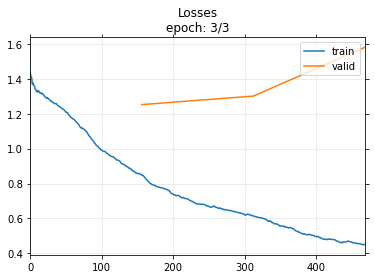

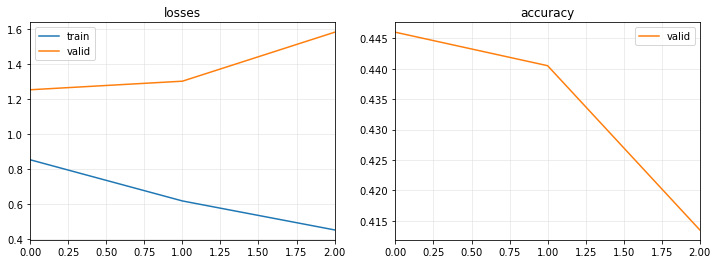

In [34]:
batch_tfms = [TSStandardize(by_var=True), Nan2Value()]
clf = TSClassifier(X, y, splits=splits_2, arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph(), verbose=True)
clf.fit_one_cycle(3, 1e-2)

In [26]:
test_probas, test_targets, test_preds = clf.get_X_preds(X[splits_2[0]], with_decoded=True)
test_probas, test_targets, test_preds

(tensor([[5.1466e-01, 4.8002e-01, 5.3202e-03, 6.4209e-07],
         [1.9115e-02, 1.5589e-01, 5.3934e-01, 2.8566e-01],
         [7.8711e-01, 2.0355e-01, 9.3348e-03, 5.4603e-06],
         ...,
         [7.0078e-01, 2.3121e-01, 6.6562e-02, 1.4467e-03],
         [5.2939e-03, 1.8081e-01, 7.9435e-01, 1.9542e-02],
         [1.4933e-05, 1.6963e-03, 2.2490e-01, 7.7339e-01]]),
 None,
 (#8000) [0,2,0,1,2,0,2,2,3,3...])

In [21]:
splits_2[1]

(#2000) [10080,10748,10372,11743,11938,11073,10293,10363,11239,10995...]

In [28]:
from cleanlab.pruning import get_noise_indices

ordered_label_errors = get_noise_indices(
    s=y[splits_2[0]],
    psx=test_probas.numpy(),
    sorted_index_method='normalized_margin', # Orders label errors
 )

In [29]:
len(ordered_label_errors)

944

In [30]:
splits_3=[[x for x in splits_2[0] if x not in ordered_label_errors], splits_2[1]]

In [23]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)

<AxesSubplot:title={'center':'0'}>

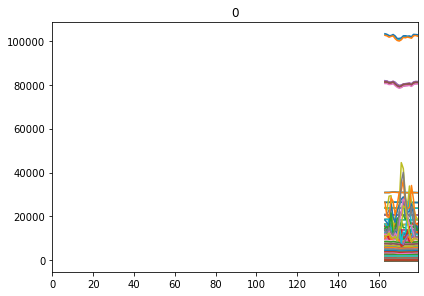

In [24]:
#check on set
show_at(dsets.valid, 1)

In [36]:
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardize(by_var=True), Nan2Value()], num_workers=0)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)
/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [26]:
#check both the train and test sets to ensure that there aren't full rows with all nulls

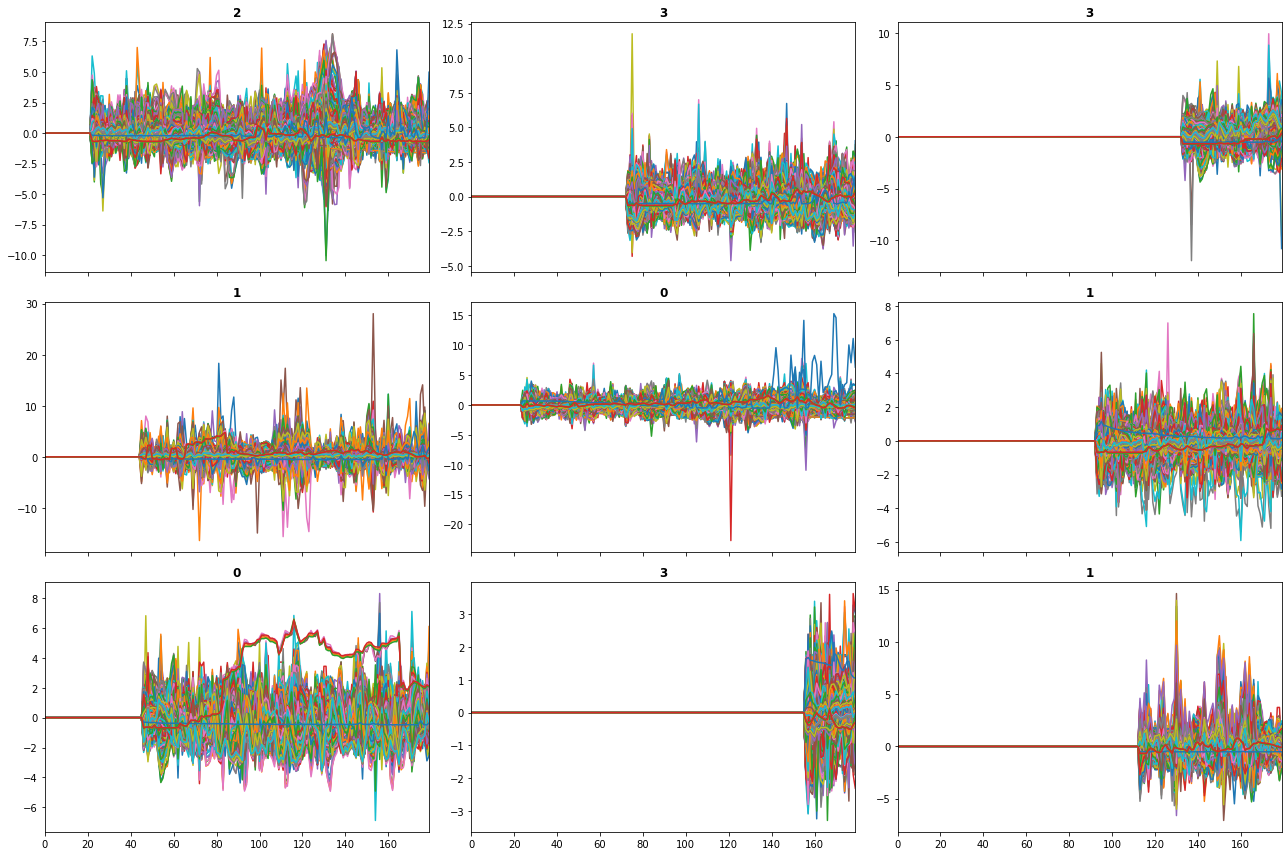

In [27]:
dls.show_batch()

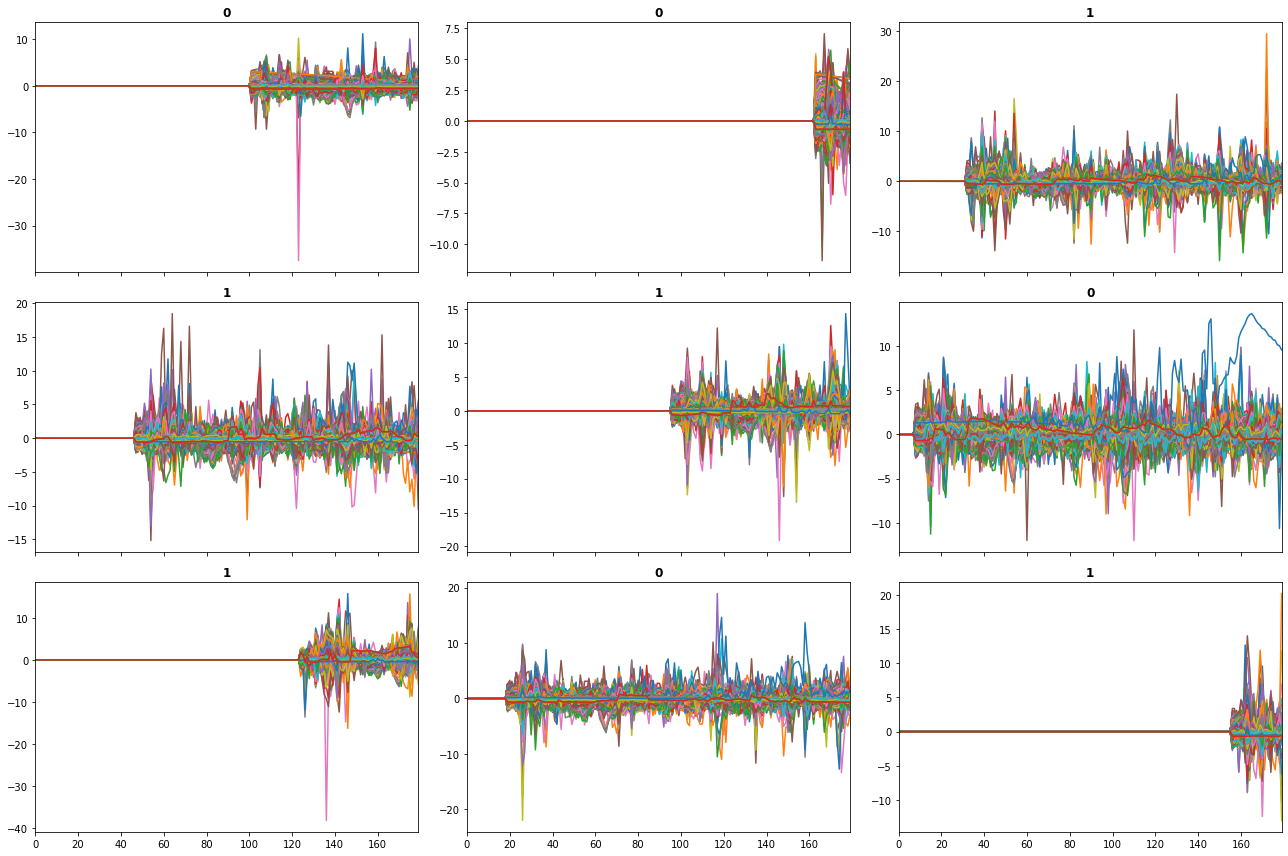

In [28]:
dls.valid.show_batch()

In [29]:
dls.c

4

In [30]:
dls.vars

774

# Lets try and train a model, in the tutorial case we are using an extremely small dataset so no conclusions should be drawn from these results they are for illustrative purposes only

In [59]:
??LabelSmoothingCrossEntropyFlat

In [69]:
#Try TST
model = TST(dls.vars, dls.c, dls.len, res_dropout=.1, fc_dropout=.8)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())

In [74]:
#try rocket
model = build_ts_model(ROCKET, dls=dls) 
X_train, y_train = create_rocket_features(dls.train, model)
X_valid, y_valid = create_rocket_features(dls.valid, model)
X_train.shape, X_valid.shape

((8000, 20000), (4000, 20000))

In [75]:
from sklearn.linear_model import RidgeClassifierCV
ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
ridge.fit(X_train, y_train)
print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')

alpha: 1.00E-01  train: 0.96500  valid: 0.54200


In [39]:
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)

In [34]:
#old
model = LSTM(dls.vars, 
                    dls.c,
                    hidden_size=200, 
                    n_layers=5, 
                    rnn_dropout=.8,
                    bidirectional=False,
                    fc_dropout=.8)
learn = Learner(dls, model, metrics=accuracy)



In [37]:
#{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 100, 'n_layers': 5, 'plus': False, 'rnn_dropout': 0.2}
model = LSTM(dls.vars, 
             dls.c,             
             bias=True,
             bidirectional=True,        
             hidden_size=100, 
             n_layers=5, 
             rnn_dropout=.2,             
             fc_dropout=.6)
learn = Learner(dls, model, metrics=accuracy)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.013182567432522774)

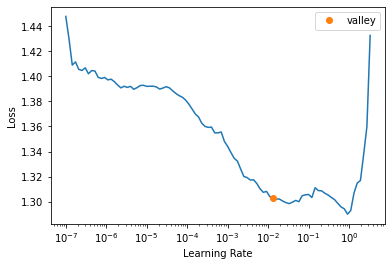

In [40]:
learn.lr_find()

In [38]:
#lstm
learn.fit_one_cycle(5, lr_max=1e-3)

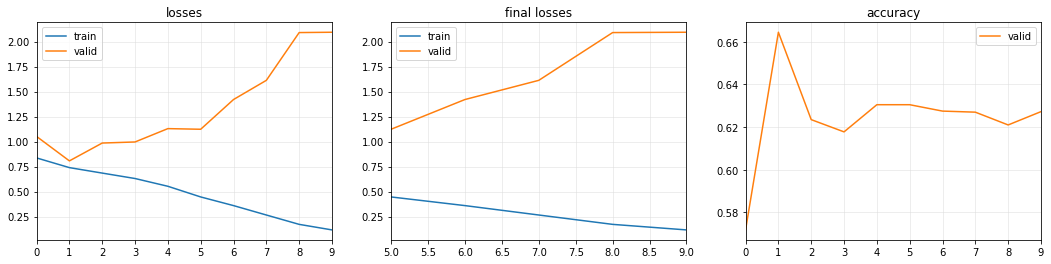

In [52]:
learn.recorder.plot_metrics()

### Results


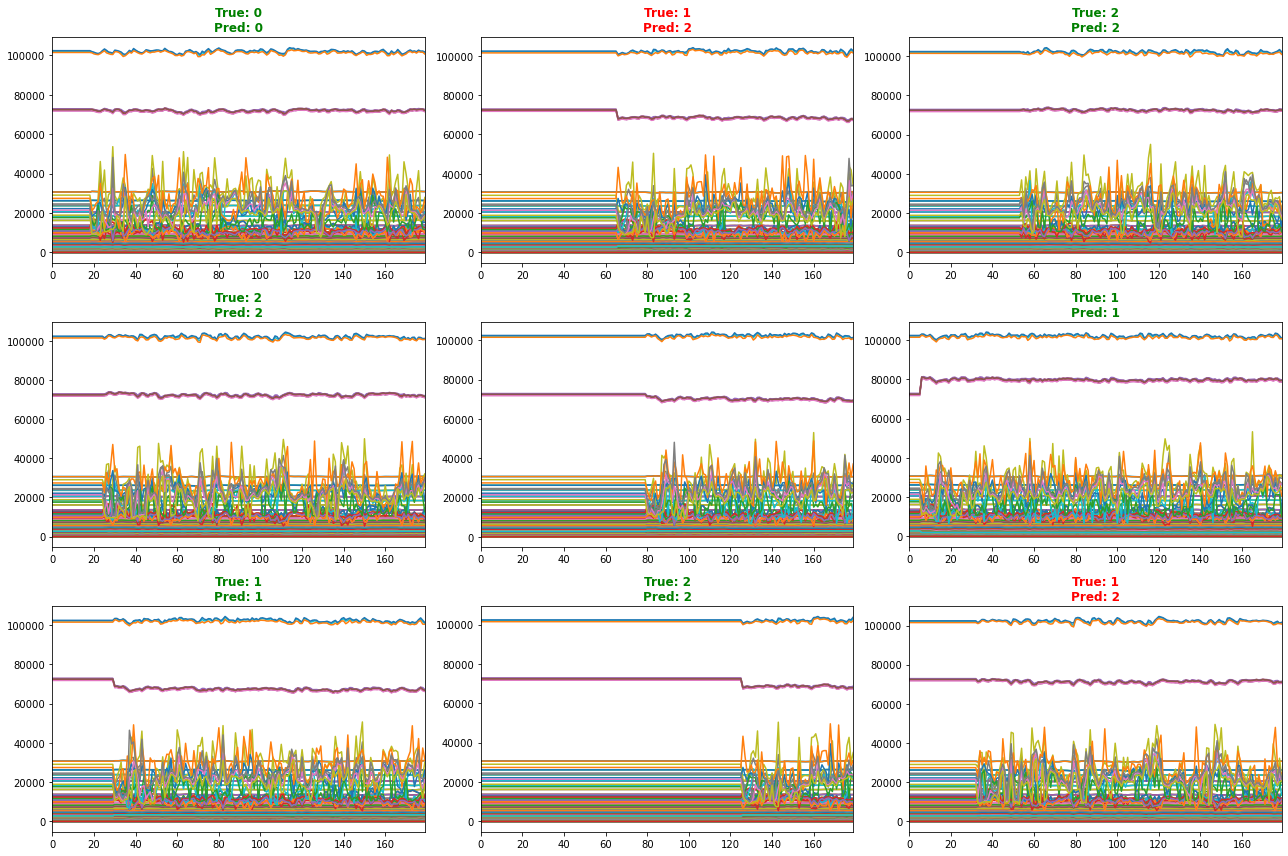

In [44]:
learn.show_results()

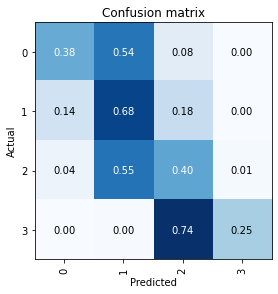

In [44]:
#d,t = flatten_check(interp.decoded, interp.targs)
#print(str(skm.accuracy_score(t, d)))
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)


In [33]:
def accuracy_local(interp):
    cm = interp.confusion_matrix()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    d,t = flatten_check(interp.decoded, interp.targs)
    return skm.accuracy_score(t, d)

In [24]:
from hyperopt import tpe, hp, fmin

In [25]:
arch_list = ['InceptionTimePlus', 'XceptionTimePlus', 'InceptionTimeXLPlus']#, 'mWDN', 'FCN', 'ResNet', 'xresnet1d34', 'ResCNN', 'LSTM', 'LSTM_FCN']
inception_arch_list = ['InceptionTimePlus', 'InceptionTimePlus17x17', 'InceptionTimePlus32x32', 'InceptionTimePlus47x47', 'InceptionTimePlus62x62', 'InceptionTimeXLPlus']

In [36]:
def objective(params):
    #arch, levels = params['arch'], params['levels']
    print(params)
    arch, ks, bottleneck, coord, dropout = params['arch'], params['ks'], params['bottleneck'], params['coord'], params['dropout']
    #create the dataloader
    #shouldn't be necessary, but there must be a bug which causes teh tfms to stop being executed on the validation set after a run
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardize(by_var=True), Nan2Value()], num_workers=0)

    model = None
    if arch == 'InceptionTime':
        model = InceptionTime(dls.vars, dls.c)
    elif arch == 'InceptionTimePlus':
        model = InceptionTimePlus(dls.vars, dls.c, bottleneck=bottleneck, coord=coord, conv_dropout=dropout)
    elif arch == 'InceptionTimePlus17x17':
        model = InceptionTimePlus(dls.vars, dls.c, bottleneck=bottleneck, coord=coord, conv_dropout=dropout)
    elif arch == 'InceptionTimePlus32x32':
        model = InceptionTimePlus(dls.vars, dls.c, bottleneck=bottleneck, coord=coord, conv_dropout=dropout)
    elif arch == 'InceptionTimePlus47x47':
        model = InceptionTimePlus(dls.vars, dls.c, bottleneck=bottleneck, coord=coord, conv_dropout=dropout)
    elif arch == 'InceptionTimePlus62x62':
        model = InceptionTimePlus(dls.vars, dls.c, bottleneck=bottleneck, coord=coord, conv_dropout=dropout)
    elif arch == 'InceptionTimeXLPlus':
        model = InceptionTimeXLPlus(dls.vars, dls.c, bottleneck=bottleneck, coord=coord, conv_dropout=dropout)
    elif arch == 'XceptionTime':
        model = XceptionTime(dls.vars, dls.c)
    elif arch == 'XceptionTimePlus':
        model = XceptionTimePlus(dls.vars, dls.c,  bottleneck=bottleneck, coord=coord)
    elif arch == 'mWDN':
        model = mWDN(dls.vars, dls.c, seq_len=180, levels=4)
    elif arch == 'FCN':
        model = FCN(dls.vars, dls.c)
    elif arch == 'ResNet':
        model = ResNet(dls.vars, dls.c)
    elif arch == 'xresnet1d34':
        model = xresnet1d34(dls.vars, dls.c)
    elif arch == 'ResCNN':
        model = ResCNN(dls.vars, dls.c)    
    elif arch == 'LSTM':
        model = LSTM(dls.vars, dls.c)
    elif arch == 'LSTM_FCN':
        model = LSTM_FCN(dls.vars, dls.c)    
    learn = Learner(dls, model, metrics=accuracy)   
    #without oversampling
    learn.fit_one_cycle(20, lr_max=1e-2, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=5))
    learn.recorder.plot_metrics()
    interp = ClassificationInterpretation.from_learner(learn)
    conf_matrix = interp.plot_confusion_matrix(normalize=True)
    #enable us to use fmin
    return 1.0 - accuracy_local(interp)

In [35]:
def objective_lstm(params):
   
    print(params)
    hidden_size, n_layers, bias, rnn_dropout, bidirectional, fc_dropout, plus = params['hidden_size'], params['n_layers'], params['bias'], params['rnn_dropout'], params['bidirectional'], params['fc_dropout'], params['plus']
    #create the dataloader
    #shouldn't be necessary, but there must be a bug which causes teh tfms to stop being executed on the validation set after a run
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardize(by_var=True), Nan2Value()], num_workers=0)
    model = None
    if plus:
        model = LSTMPlus(dls.vars, dls.c, hidden_size=hidden_size, n_layers=n_layers, bias=bias, rnn_dropout=rnn_dropout, bidirectional=bidirectional, fc_dropout=fc_dropout)
    else:
        model = LSTM(dls.vars, dls.c, hidden_size=hidden_size, n_layers=n_layers, bias=bias, rnn_dropout=rnn_dropout, bidirectional=bidirectional, fc_dropout=fc_dropout)

    learn = Learner(dls, model, metrics=accuracy)   
    #without oversampling
    learn.fit_one_cycle(20, lr_max=1e-02, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=5))
    learn.recorder.plot_metrics()
    interp = ClassificationInterpretation.from_learner(learn)
    conf_matrix = interp.plot_confusion_matrix(normalize=True)
    #enable us to use fmin
    return 1.0 - accuracy_local(interp)

In [37]:
space = {
    'arch': hp.choice('arch', arch_list),
    'ks': hp.choice('ks', [5, 10, 40, 60, 80]),
    'bottleneck': hp.choice('bottleneck', [True, False]),
    'coord': hp.choice('coord', [True, False]),
    #'stride': hp.choice('stride', [1,3,5,7,9]),
    'dropout': hp.choice('dropout', [0., .2, .5, .8])
}

space_lstm = {
    'hidden_size': hp.choice('hidden_size', [100, 150, 200, 250]),
    'n_layers': hp.choice('n_layers', [1,5,8,10]),
    'bias': hp.choice('bias', [True, False]),
    'rnn_dropout': hp.choice('rnn_dropout', [0, .2, .4, .6, .8]),
    'bidirectional': hp.choice('bidirectional', [True, False]),
    'fc_dropout': hp.choice('fc_dropout', [0, .2, .4, .6, .8]),
    'plus': hp.choice('plus', [True, False])
}


{'arch': 'XceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.5, 'ks': 60}                               
  0%|                                                                            | 0/25 [00:00<?, ?trial/s, best loss=?]

No improvement since epoch 2: early stopping                                                                            
  0%|                                                                            | 0/25 [00:51<?, ?trial/s, best loss=?]

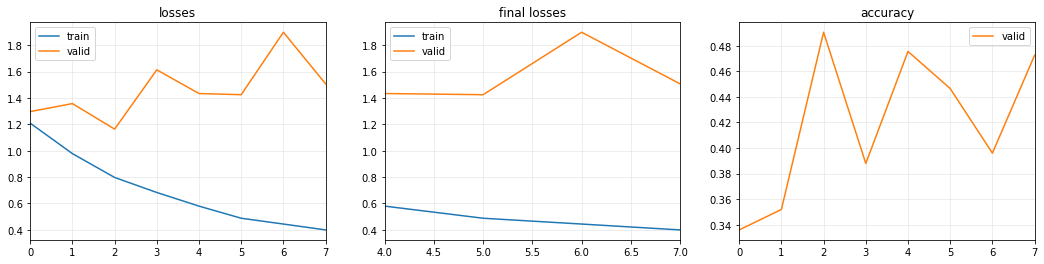

{'arch': 'XceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.5, 'ks': 80}                               
  4%|██                                                | 1/25 [00:53<21:11, 53.00s/trial, best loss: 0.5275000000000001]

No improvement since epoch 1: early stopping                                                                            
  4%|██                                                | 1/25 [01:37<21:11, 53.00s/trial, best loss: 0.5275000000000001]

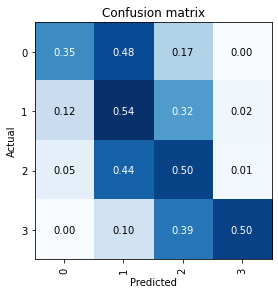

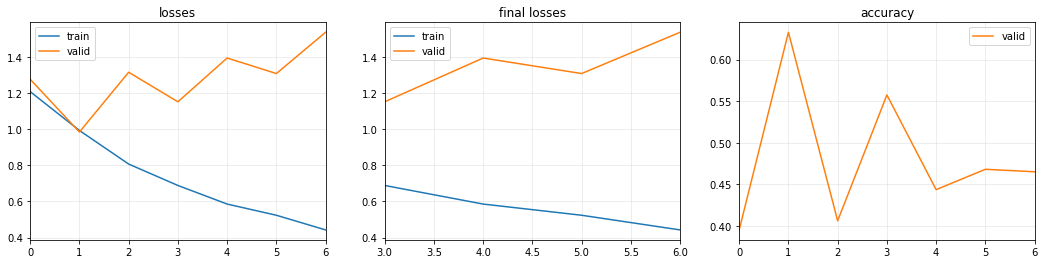

{'arch': 'InceptionTimePlus', 'bottleneck': False, 'coord': False, 'dropout': 0.5, 'ks': 40}                            
  8%|████                                              | 2/25 [01:39<18:44, 48.91s/trial, best loss: 0.5275000000000001]

No improvement since epoch 0: early stopping                                                                            
  8%|████                                              | 2/25 [02:19<18:44, 48.91s/trial, best loss: 0.5275000000000001]

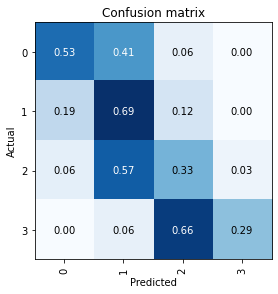

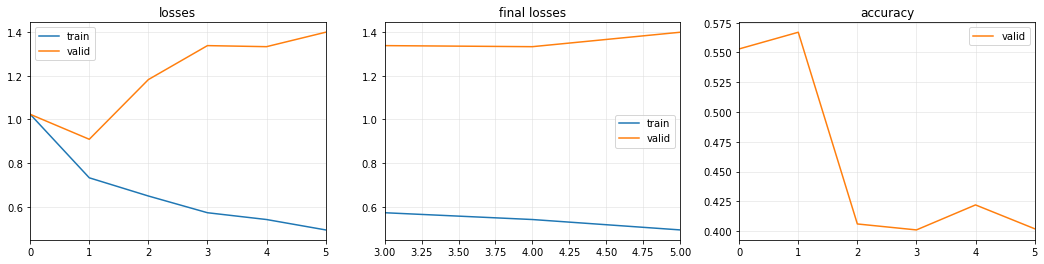

{'arch': 'InceptionTimePlus', 'bottleneck': False, 'coord': True, 'dropout': 0.2, 'ks': 5}                              
 12%|██████                                            | 3/25 [02:20<16:44, 45.66s/trial, best loss: 0.5275000000000001]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 12%|██████                                            | 3/25 [03:06<16:44, 45.66s/trial, best loss: 0.5275000000000001]

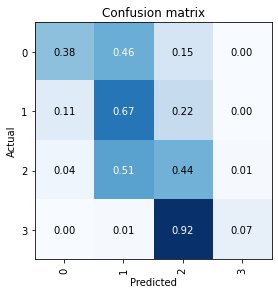

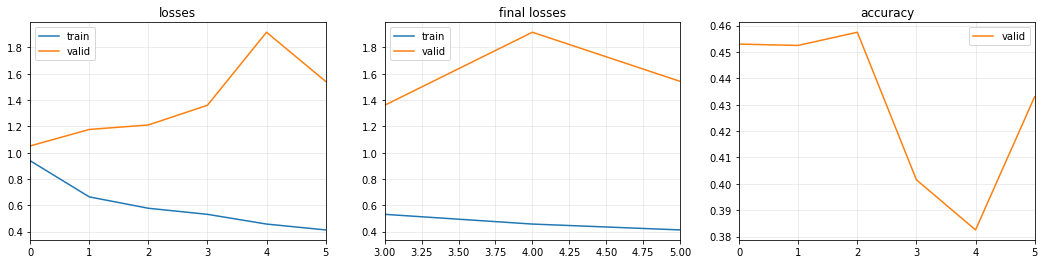

{'arch': 'InceptionTimeXLPlus', 'bottleneck': False, 'coord': False, 'dropout': 0.5, 'ks': 80}                          
 16%|████████                                          | 4/25 [03:08<16:14, 46.39s/trial, best loss: 0.5275000000000001]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 16%|████████                                          | 4/25 [04:50<16:14, 46.39s/trial, best loss: 0.5275000000000001]

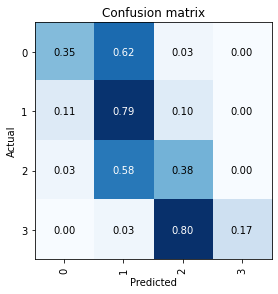

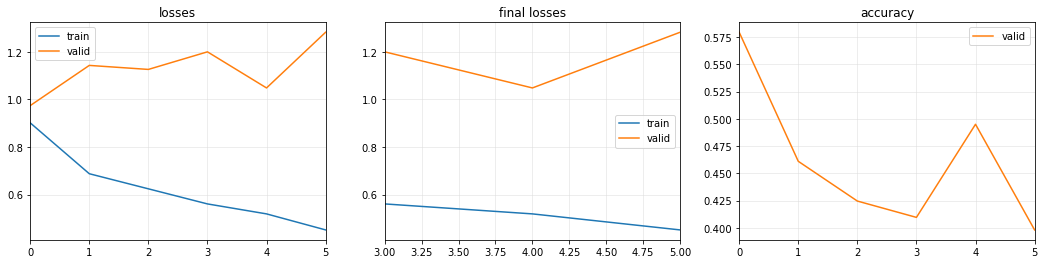

{'arch': 'XceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.0, 'ks': 10}                               
 20%|██████████                                        | 5/25 [04:52<22:23, 67.18s/trial, best loss: 0.5275000000000001]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 20%|██████████                                        | 5/25 [05:37<22:23, 67.18s/trial, best loss: 0.5275000000000001]

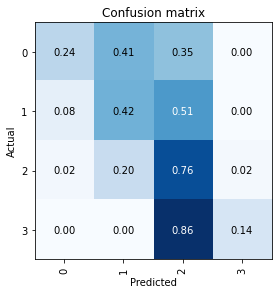

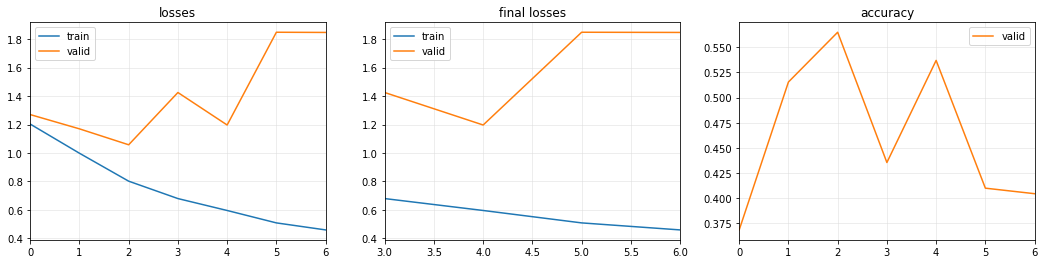

{'arch': 'XceptionTimePlus', 'bottleneck': False, 'coord': False, 'dropout': 0.0, 'ks': 80}                             
 24%|████████████                                      | 6/25 [05:38<18:59, 59.99s/trial, best loss: 0.5275000000000001]

No improvement since epoch 1: early stopping                                                                            
 24%|████████████                                      | 6/25 [06:34<18:59, 59.99s/trial, best loss: 0.5275000000000001]

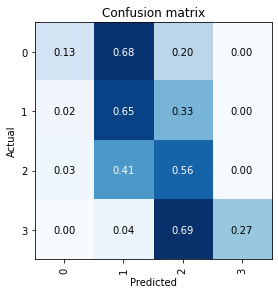

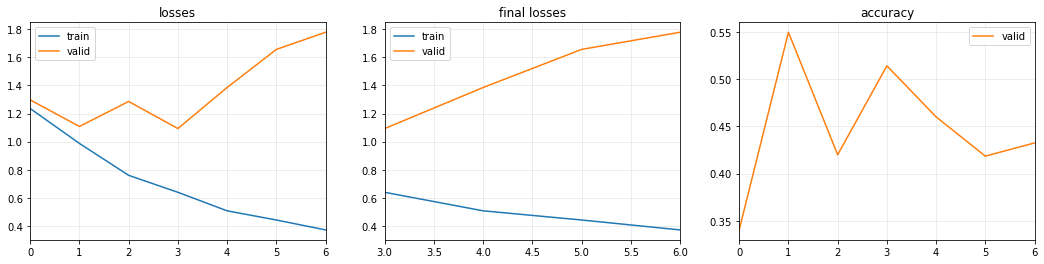

{'arch': 'XceptionTimePlus', 'bottleneck': True, 'coord': False, 'dropout': 0.5, 'ks': 10}                              
 28%|██████████████                                    | 7/25 [06:35<17:44, 59.16s/trial, best loss: 0.5275000000000001]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 28%|██████████████                                    | 7/25 [07:14<17:44, 59.16s/trial, best loss: 0.5275000000000001]

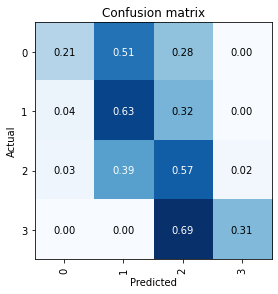

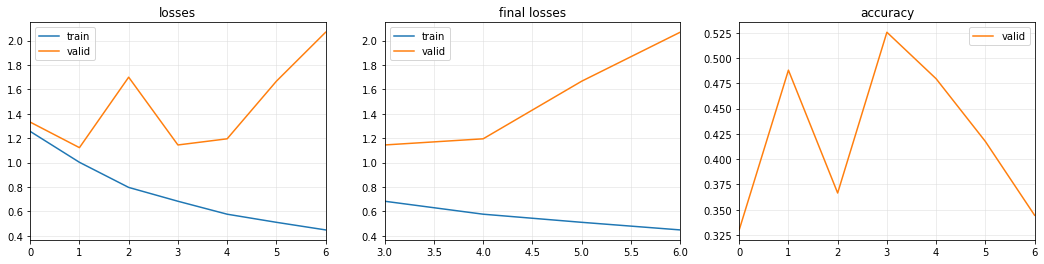

{'arch': 'InceptionTimeXLPlus', 'bottleneck': True, 'coord': False, 'dropout': 0.8, 'ks': 40}                           
 32%|████████████████                                  | 8/25 [07:15<14:58, 52.85s/trial, best loss: 0.5275000000000001]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 3: early stopping                                                                            
 32%|████████████████                                  | 8/25 [08:54<14:58, 52.85s/trial, best loss: 0.5275000000000001]

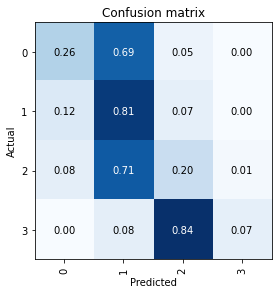

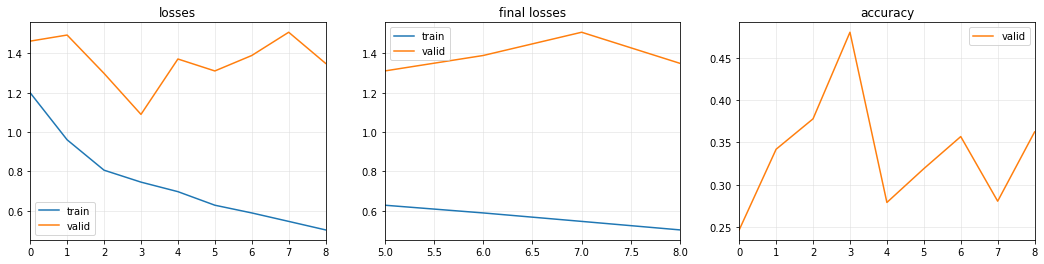

{'arch': 'XceptionTimePlus', 'bottleneck': False, 'coord': True, 'dropout': 0.5, 'ks': 5}                               
 36%|██████████████████                                | 9/25 [08:55<18:04, 67.76s/trial, best loss: 0.5275000000000001]

No improvement since epoch 1: early stopping                                                                            
 36%|██████████████████                                | 9/25 [09:57<18:04, 67.76s/trial, best loss: 0.5275000000000001]

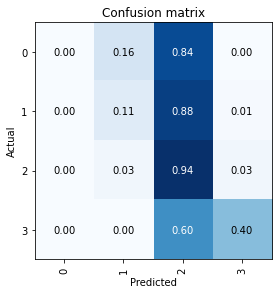

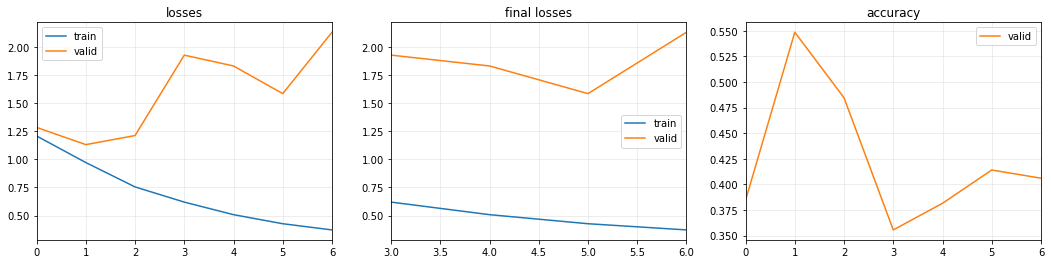

{'arch': 'XceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.5, 'ks': 40}                               
 40%|███████████████████▌                             | 10/25 [09:58<16:34, 66.31s/trial, best loss: 0.5275000000000001]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 5: early stopping                                                                            
 40%|███████████████████▌                             | 10/25 [11:06<16:34, 66.31s/trial, best loss: 0.5275000000000001]

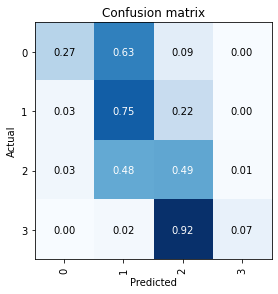

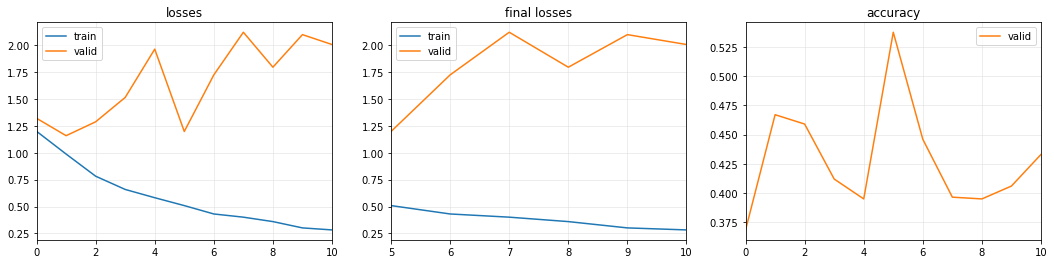

{'arch': 'InceptionTimePlus', 'bottleneck': True, 'coord': False, 'dropout': 0.0, 'ks': 10}                             
 44%|█████████████████████▌                           | 11/25 [11:07<15:39, 67.10s/trial, best loss: 0.5275000000000001]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 3: early stopping                                                                            
 44%|█████████████████████▌                           | 11/25 [11:49<15:39, 67.10s/trial, best loss: 0.5275000000000001]

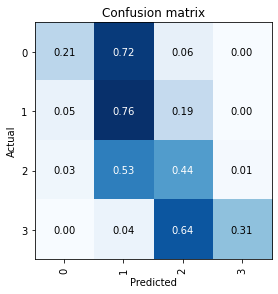

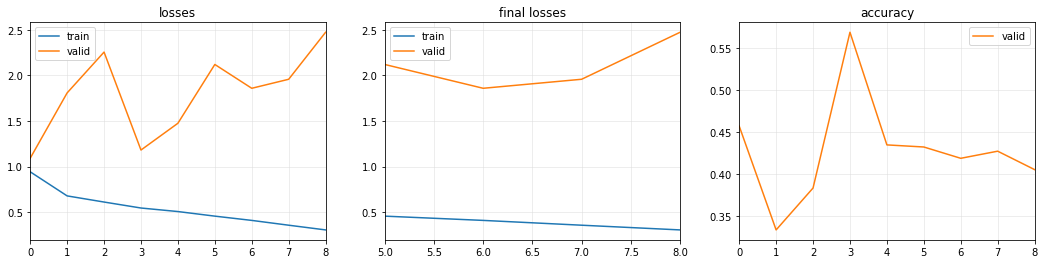

{'arch': 'XceptionTimePlus', 'bottleneck': False, 'coord': False, 'dropout': 0.2, 'ks': 40}                             
 48%|███████████████████████▌                         | 12/25 [11:50<12:57, 59.79s/trial, best loss: 0.5275000000000001]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 48%|███████████████████████▌                         | 12/25 [12:37<12:57, 59.79s/trial, best loss: 0.5275000000000001]

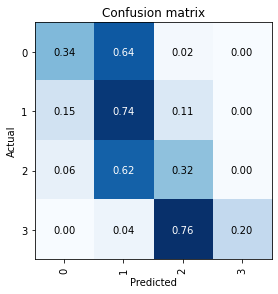

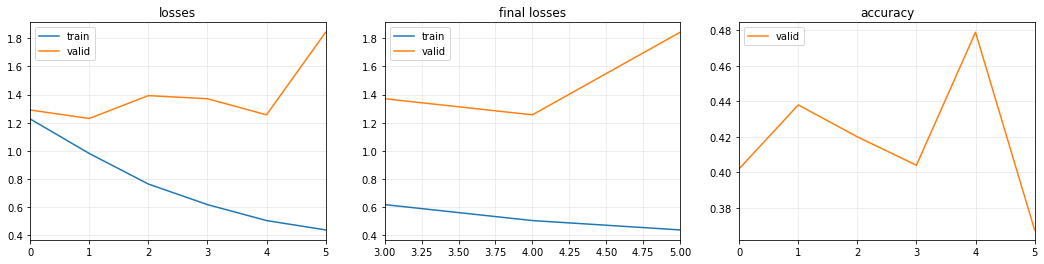

{'arch': 'XceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.2, 'ks': 60}                               
 52%|█████████████████████████▍                       | 13/25 [12:38<11:14, 56.21s/trial, best loss: 0.5275000000000001]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 52%|█████████████████████████▍                       | 13/25 [13:22<11:14, 56.21s/trial, best loss: 0.5275000000000001]

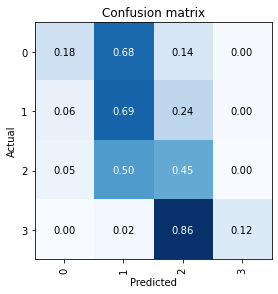

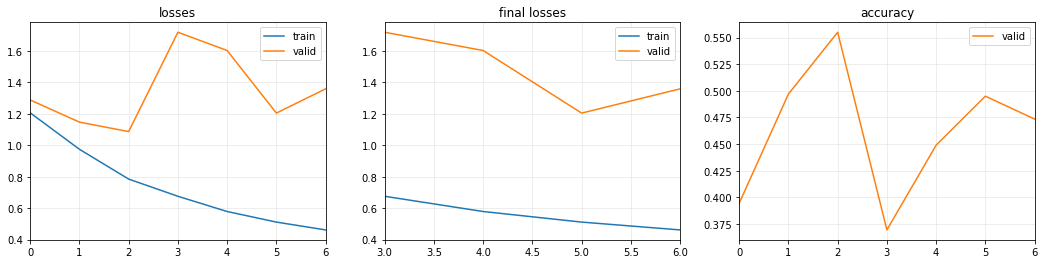

{'arch': 'InceptionTimePlus', 'bottleneck': True, 'coord': False, 'dropout': 0.2, 'ks': 40}                             
 56%|██████████████████████████████████▏                          | 14/25 [13:23<09:41, 52.84s/trial, best loss: 0.5265]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 4: early stopping                                                                            
 56%|██████████████████████████████████▏                          | 14/25 [14:10<09:41, 52.84s/trial, best loss: 0.5265]

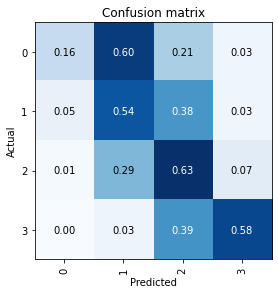

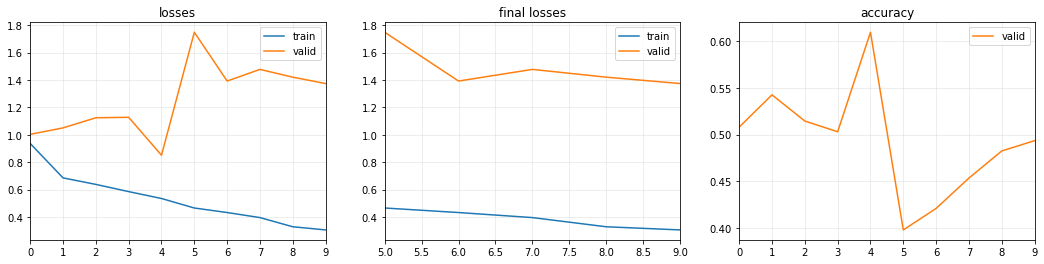

{'arch': 'InceptionTimeXLPlus', 'bottleneck': True, 'coord': False, 'dropout': 0.0, 'ks': 5}                            
 60%|████████████████████████████████████▌                        | 15/25 [14:11<08:33, 51.36s/trial, best loss: 0.5065]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 60%|████████████████████████████████████▌                        | 15/25 [15:14<08:33, 51.36s/trial, best loss: 0.5065]

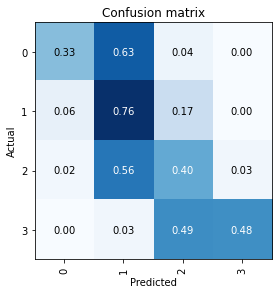

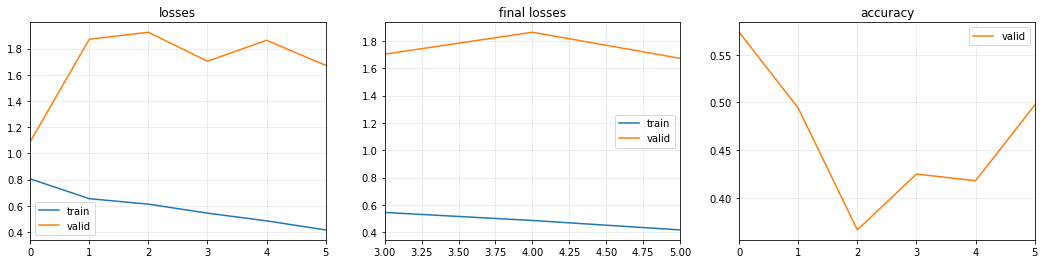

{'arch': 'InceptionTimeXLPlus', 'bottleneck': True, 'coord': False, 'dropout': 0.8, 'ks': 60}                           
 64%|███████████████████████████████████████▋                      | 16/25 [15:16<08:18, 55.36s/trial, best loss: 0.503]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 64%|███████████████████████████████████████▋                      | 16/25 [16:31<08:18, 55.36s/trial, best loss: 0.503]

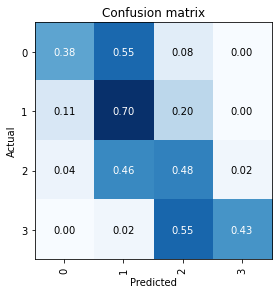

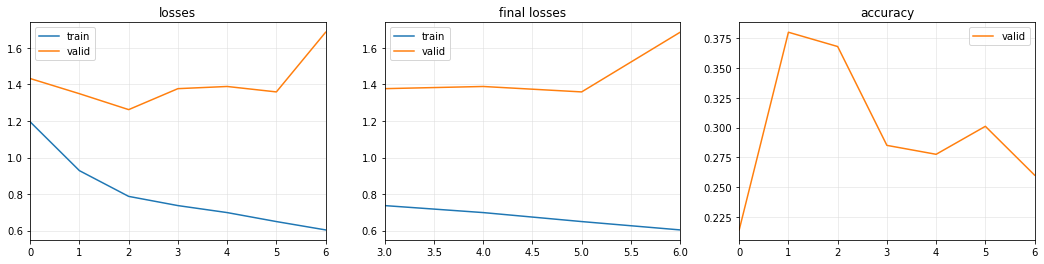

{'arch': 'InceptionTimePlus', 'bottleneck': True, 'coord': False, 'dropout': 0.8, 'ks': 40}                             
 68%|██████████████████████████████████████████▏                   | 17/25 [16:33<08:14, 61.79s/trial, best loss: 0.503]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 68%|██████████████████████████████████████████▏                   | 17/25 [17:06<08:14, 61.79s/trial, best loss: 0.503]

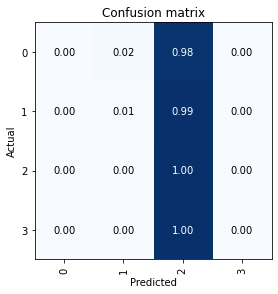

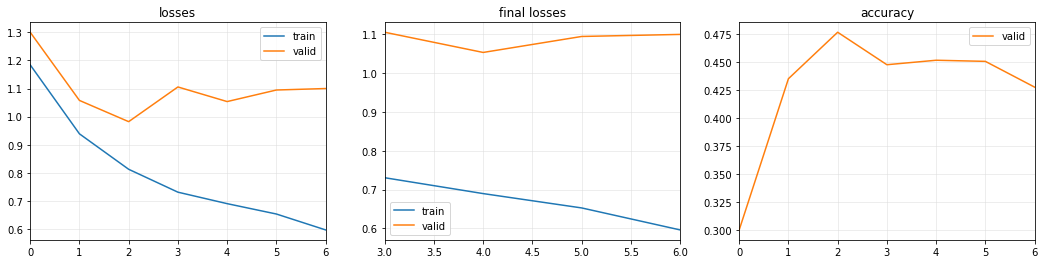

{'arch': 'InceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.8, 'ks': 80}                              
 72%|████████████████████████████████████████████▋                 | 18/25 [17:07<06:15, 53.61s/trial, best loss: 0.503]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 72%|████████████████████████████████████████████▋                 | 18/25 [17:49<06:15, 53.61s/trial, best loss: 0.503]

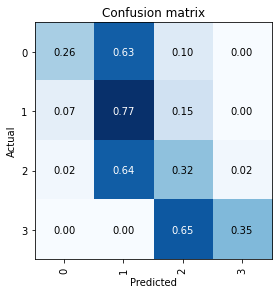

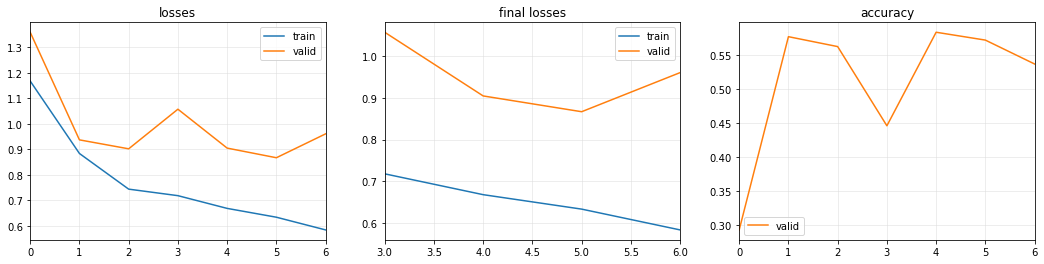

{'arch': 'InceptionTimeXLPlus', 'bottleneck': True, 'coord': True, 'dropout': 0.5, 'ks': 40}                            
 76%|██████████████████████████████████████████████▎              | 19/25 [17:50<05:02, 50.38s/trial, best loss: 0.4635]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 76%|██████████████████████████████████████████████▎              | 19/25 [19:07<05:02, 50.38s/trial, best loss: 0.4635]

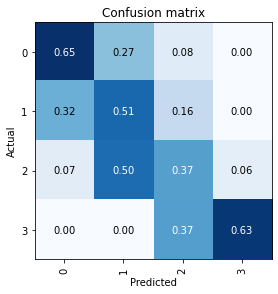

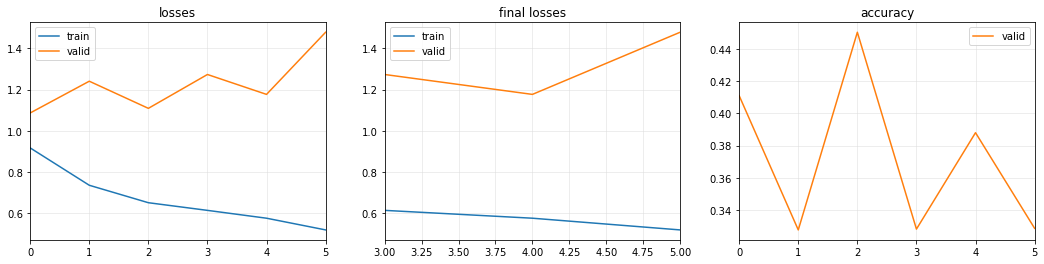

{'arch': 'InceptionTimeXLPlus', 'bottleneck': True, 'coord': True, 'dropout': 0.0, 'ks': 5}                             
 80%|████████████████████████████████████████████████▊            | 20/25 [19:09<04:54, 58.88s/trial, best loss: 0.4635]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 80%|████████████████████████████████████████████████▊            | 20/25 [20:24<04:54, 58.88s/trial, best loss: 0.4635]

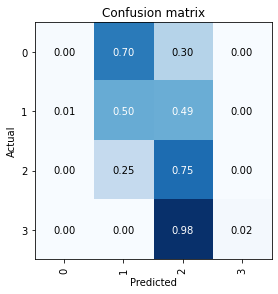

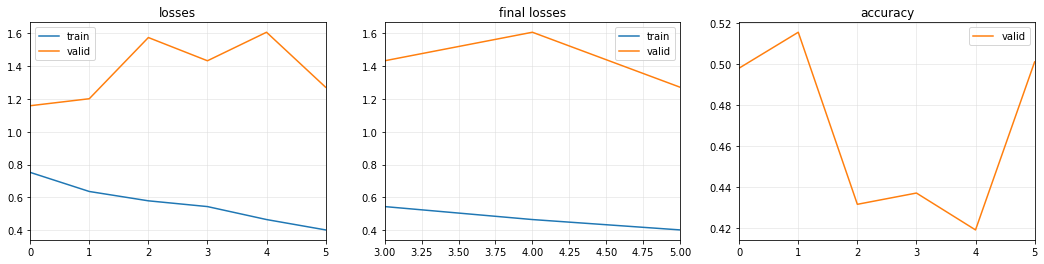

{'arch': 'InceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.8, 'ks': 5}                               
 84%|███████████████████████████████████████████████████▏         | 21/25 [20:25<04:16, 64.16s/trial, best loss: 0.4635]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 84%|███████████████████████████████████████████████████▏         | 21/25 [21:07<04:16, 64.16s/trial, best loss: 0.4635]

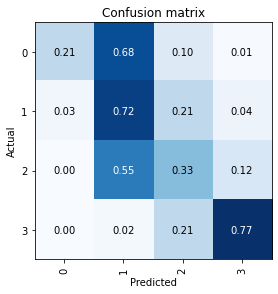

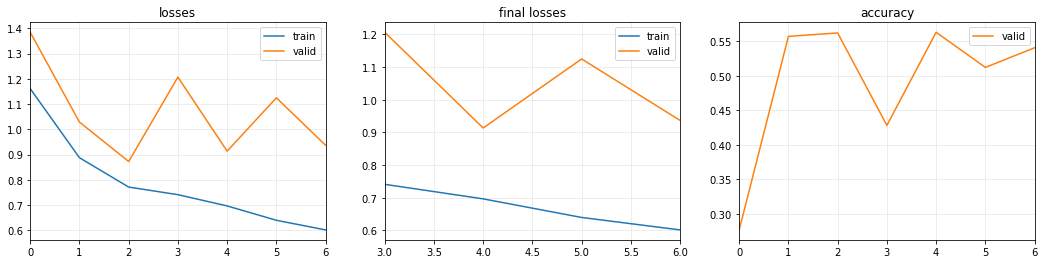

{'arch': 'InceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.8, 'ks': 80}                              
 88%|█████████████████████████████████████████████████████▋       | 22/25 [21:08<02:53, 57.73s/trial, best loss: 0.4595]

No improvement since epoch 2: early stopping                                                                            
 88%|█████████████████████████████████████████████████████▋       | 22/25 [21:55<02:53, 57.73s/trial, best loss: 0.4595]

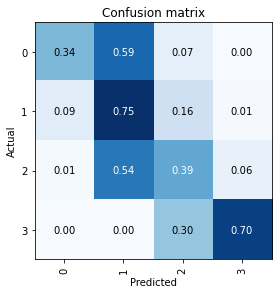

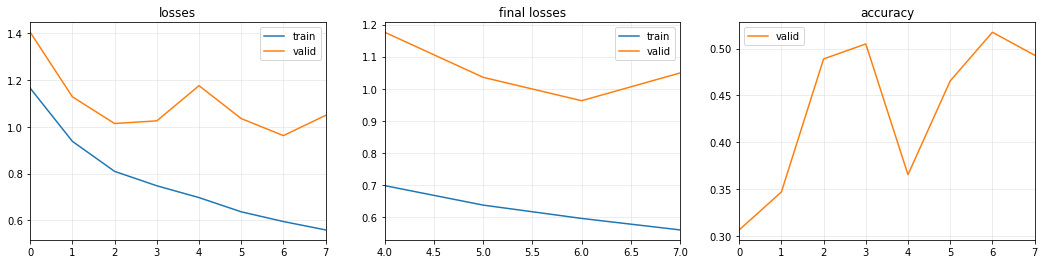

{'arch': 'InceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.8, 'ks': 5}                               
 92%|████████████████████████████████████████████████████████     | 23/25 [21:56<01:49, 54.90s/trial, best loss: 0.4595]

No improvement since epoch 2: early stopping                                                                            
 92%|████████████████████████████████████████████████████████     | 23/25 [22:43<01:49, 54.90s/trial, best loss: 0.4595]

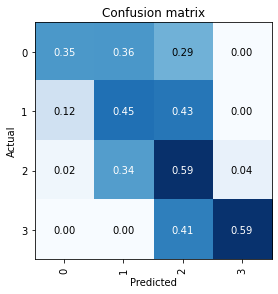

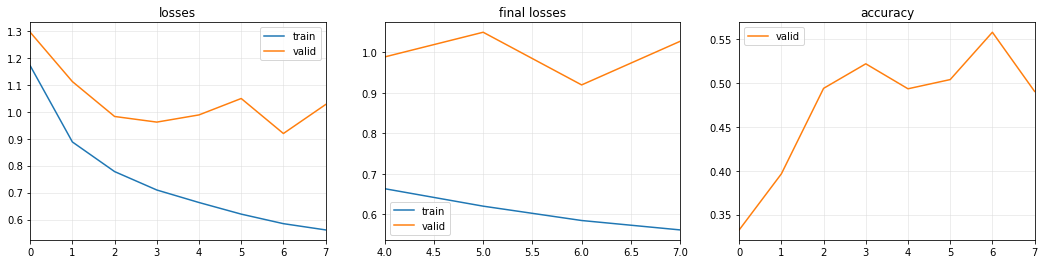

{'arch': 'InceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.8, 'ks': 80}                              
 96%|██████████████████████████████████████████████████████████▌  | 24/25 [22:45<00:52, 52.92s/trial, best loss: 0.4595]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 2: early stopping                                                                            
 96%|██████████████████████████████████████████████████████████▌  | 24/25 [23:32<00:52, 52.92s/trial, best loss: 0.4595]

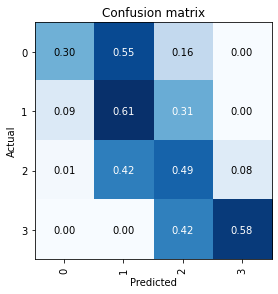

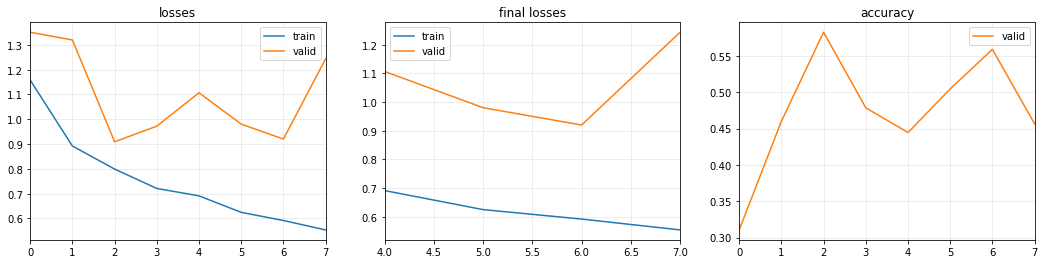

100%|█████████████████████████████████████████████████████████████| 25/25 [23:33<00:00, 56.55s/trial, best loss: 0.4595]
{'arch': 0, 'bottleneck': 0, 'coord': 0, 'dropout': 3, 'ks': 0}


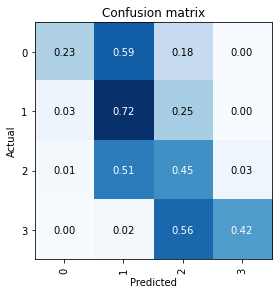

In [38]:
best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=25
)
print(best)

In [39]:
best

{'arch': 0, 'bottleneck': 0, 'coord': 0, 'dropout': 3, 'ks': 0}

{'bias': True, 'bidirectional': False, 'fc_dropout': 0.8, 'hidden_size': 100, 'n_layers': 1, 'plus': False, 'rnn_dropout': 0.8}
  0%|                                                                            | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



No improvement since epoch 0: early stopping                                                                            
  0%|                                                                            | 0/25 [00:21<?, ?trial/s, best loss=?]

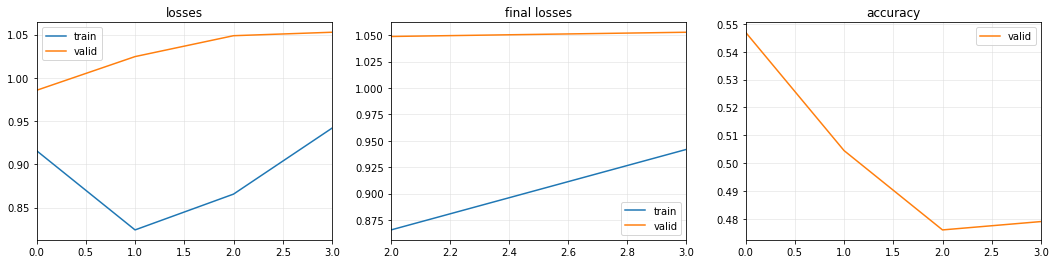

{'bias': False, 'bidirectional': True, 'fc_dropout': 0.2, 'hidden_size': 200, 'n_layers': 10, 'plus': False, 'rnn_dropout': 0.2}
  4%|██▌                                                            | 1/25 [00:22<09:01, 22.57s/trial, best loss: 0.521]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
  4%|██▌                                                            | 1/25 [05:25<09:01, 22.57s/trial, best loss: 0.521]

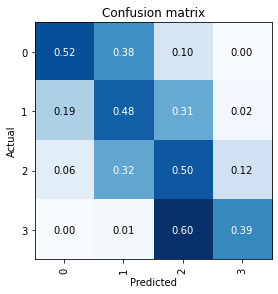

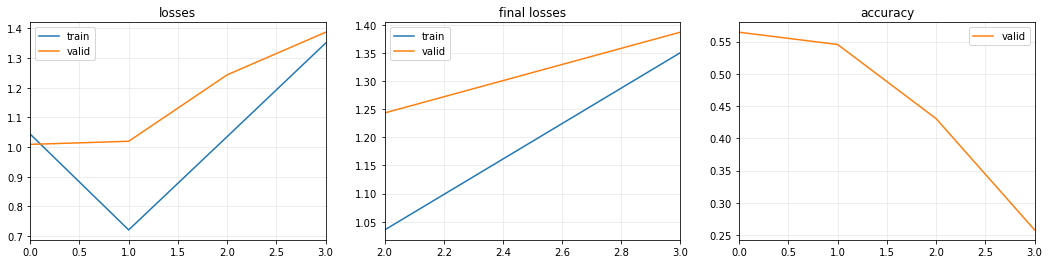

{'bias': False, 'bidirectional': True, 'fc_dropout': 0, 'hidden_size': 200, 'n_layers': 1, 'plus': True, 'rnn_dropout': 0.6}
  8%|████▊                                                       | 2/25 [05:29<1:12:51, 190.07s/trial, best loss: 0.521]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



No improvement since epoch 0: early stopping                                                                            
  8%|████▊                                                       | 2/25 [06:03<1:12:51, 190.07s/trial, best loss: 0.521]

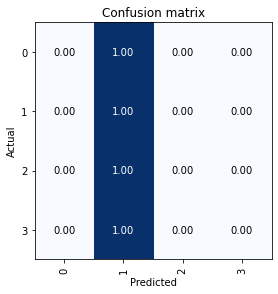

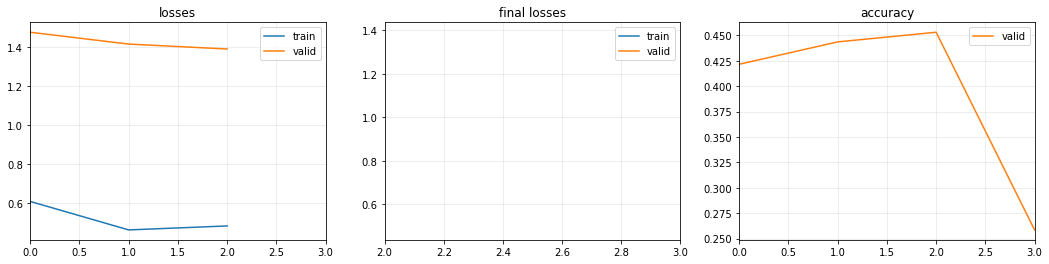

{'bias': False, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 150, 'n_layers': 10, 'plus': False, 'rnn_dropout': 0.4}
 12%|███████▍                                                      | 3/25 [06:05<43:46, 119.39s/trial, best loss: 0.521]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 12%|███████▍                                                      | 3/25 [10:23<43:46, 119.39s/trial, best loss: 0.521]

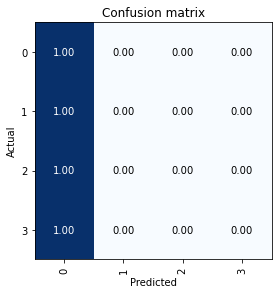

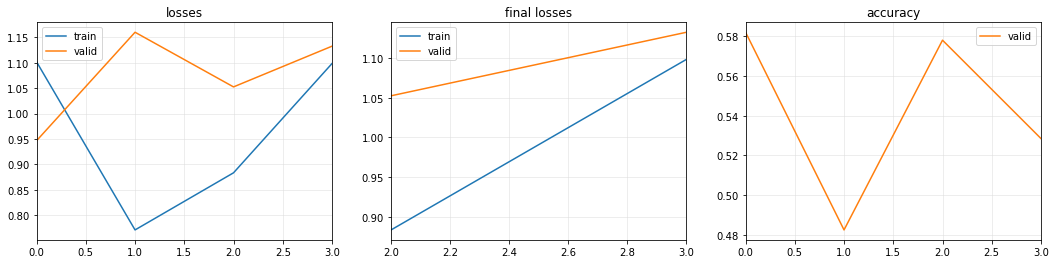

{'bias': True, 'bidirectional': False, 'fc_dropout': 0.8, 'hidden_size': 250, 'n_layers': 5, 'plus': False, 'rnn_dropout': 0.2}
 16%|███████▎                                      | 4/25 [10:27<1:01:32, 175.82s/trial, best loss: 0.47150000000000003]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 16%|███████▎                                      | 4/25 [11:59<1:01:32, 175.82s/trial, best loss: 0.47150000000000003]

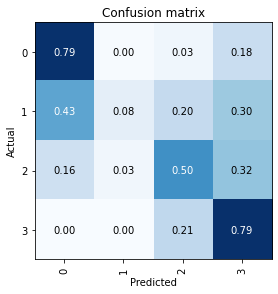

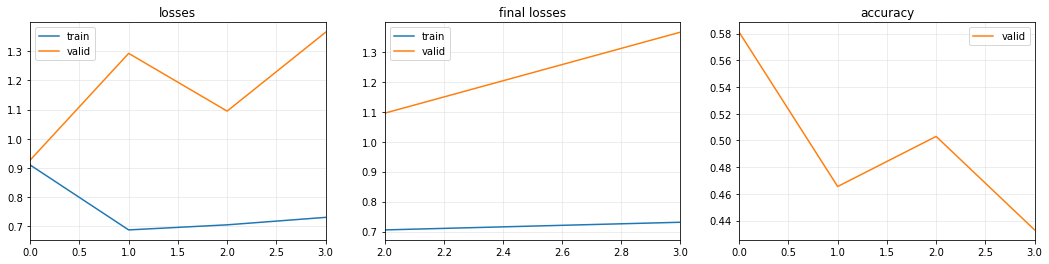

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 250, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0}
 20%|█████████▌                                      | 5/25 [12:01<48:44, 146.21s/trial, best loss: 0.47150000000000003]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 20%|█████████▌                                      | 5/25 [15:30<48:44, 146.21s/trial, best loss: 0.47150000000000003]

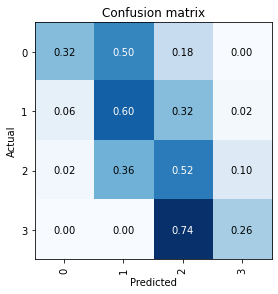

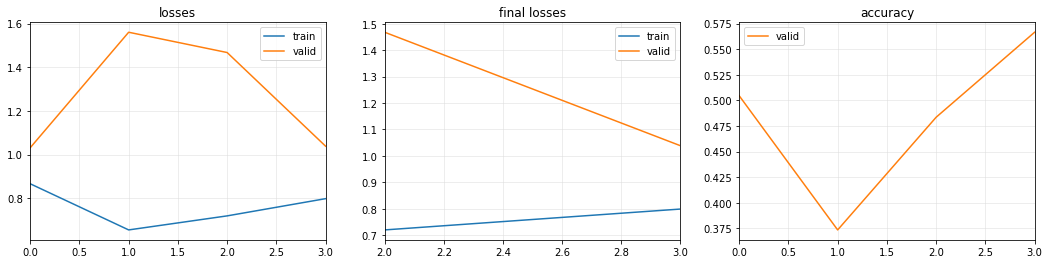

{'bias': False, 'bidirectional': False, 'fc_dropout': 0.4, 'hidden_size': 100, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0}
 24%|██████████████▋                                              | 6/25 [15:35<53:37, 169.34s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 24%|██████████████▋                                              | 6/25 [16:27<53:37, 169.34s/trial, best loss: 0.4335]

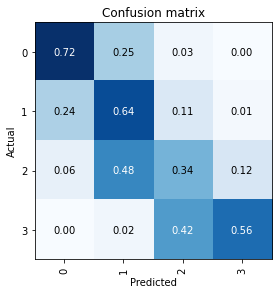

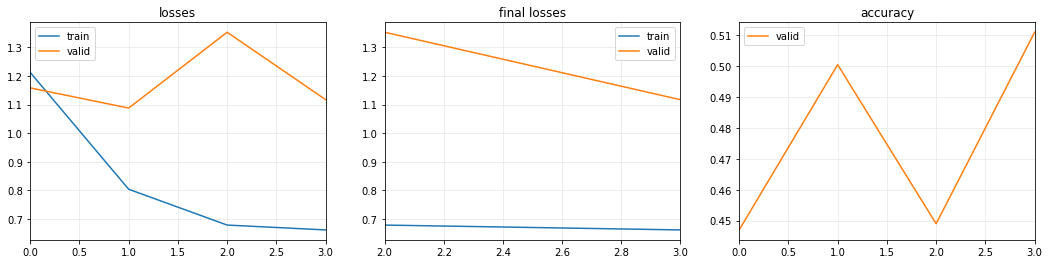

{'bias': False, 'bidirectional': False, 'fc_dropout': 0, 'hidden_size': 100, 'n_layers': 10, 'plus': True, 'rnn_dropout': 0.8}
 28%|█████████████████                                            | 7/25 [16:29<39:32, 131.81s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 28%|█████████████████                                            | 7/25 [19:07<39:32, 131.81s/trial, best loss: 0.4335]

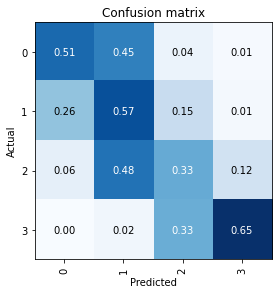

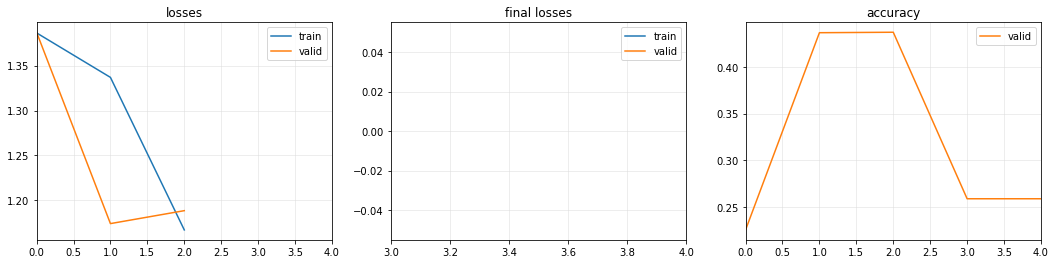

{'bias': True, 'bidirectional': True, 'fc_dropout': 0, 'hidden_size': 100, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0.4}
 32%|███████████████████▌                                         | 8/25 [19:10<39:54, 140.85s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 32%|███████████████████▌                                         | 8/25 [22:03<39:54, 140.85s/trial, best loss: 0.4335]

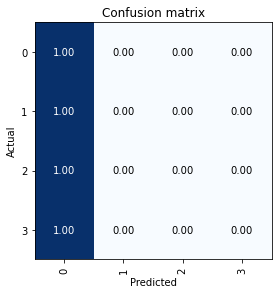

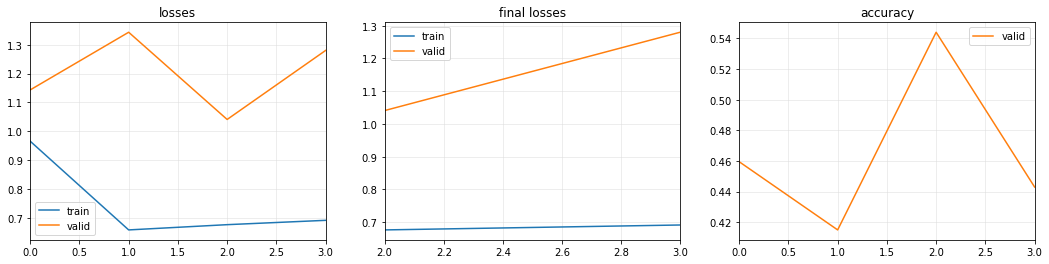

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 150, 'n_layers': 10, 'plus': True, 'rnn_dropout': 0.4}
 36%|█████████████████████▉                                       | 9/25 [22:06<40:30, 151.88s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 36%|█████████████████████▉                                       | 9/25 [27:30<40:30, 151.88s/trial, best loss: 0.4335]

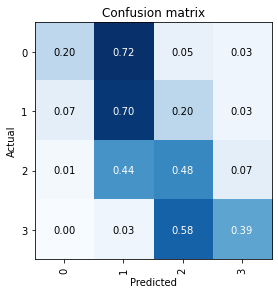

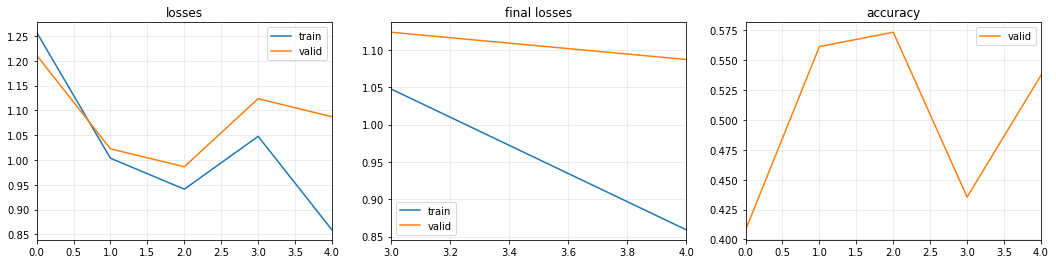

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.4, 'hidden_size': 150, 'n_layers': 10, 'plus': True, 'rnn_dropout': 0.8}
 40%|████████████████████████                                    | 10/25 [27:34<51:33, 206.26s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 40%|████████████████████████                                    | 10/25 [31:53<51:33, 206.26s/trial, best loss: 0.4335]

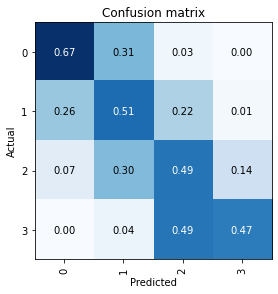

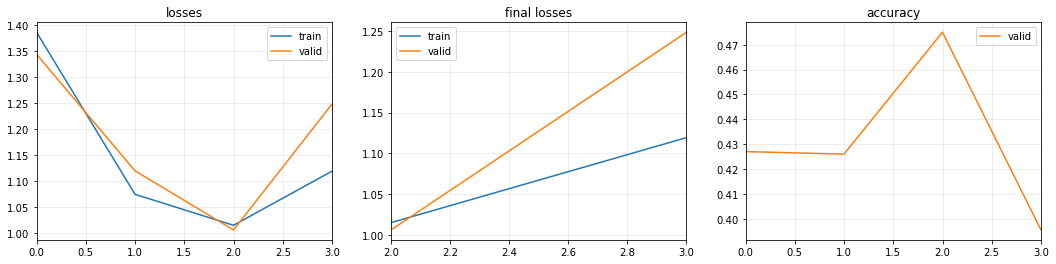

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 200, 'n_layers': 5, 'plus': True, 'rnn_dropout': 0.2}
 44%|██████████████████████████▍                                 | 11/25 [31:57<52:13, 223.80s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 44%|██████████████████████████▍                                 | 11/25 [34:30<52:13, 223.80s/trial, best loss: 0.4335]

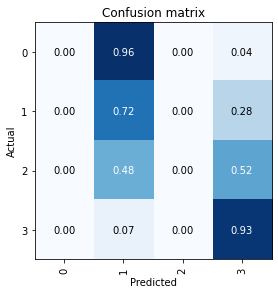

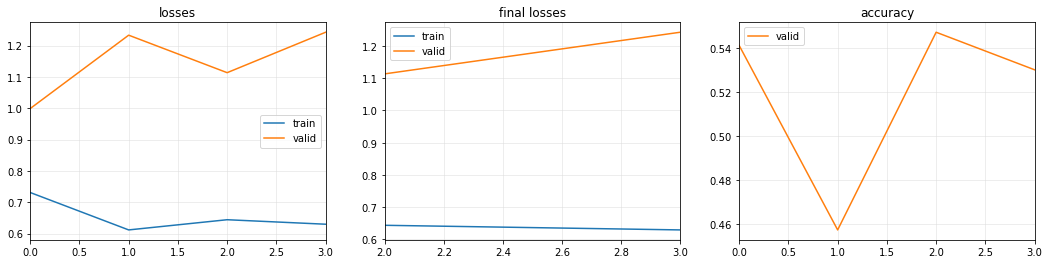

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.2, 'hidden_size': 250, 'n_layers': 5, 'plus': False, 'rnn_dropout': 0.2}
 48%|████████████████████████████▊                               | 12/25 [34:33<44:00, 203.11s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 48%|████████████████████████████▊                               | 12/25 [37:35<44:00, 203.11s/trial, best loss: 0.4335]

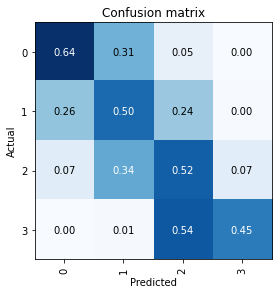

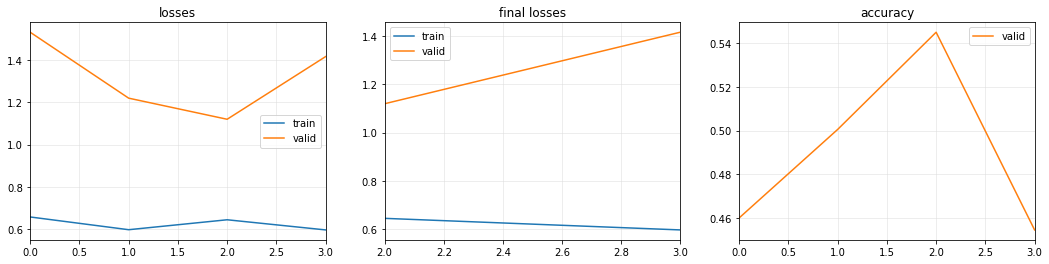

{'bias': False, 'bidirectional': True, 'fc_dropout': 0.8, 'hidden_size': 200, 'n_layers': 5, 'plus': True, 'rnn_dropout': 0.4}
 52%|███████████████████████████████▏                            | 13/25 [37:38<39:31, 197.66s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 52%|███████████████████████████████▏                            | 13/25 [40:49<39:31, 197.66s/trial, best loss: 0.4335]

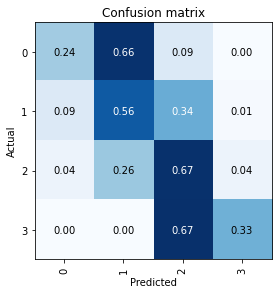

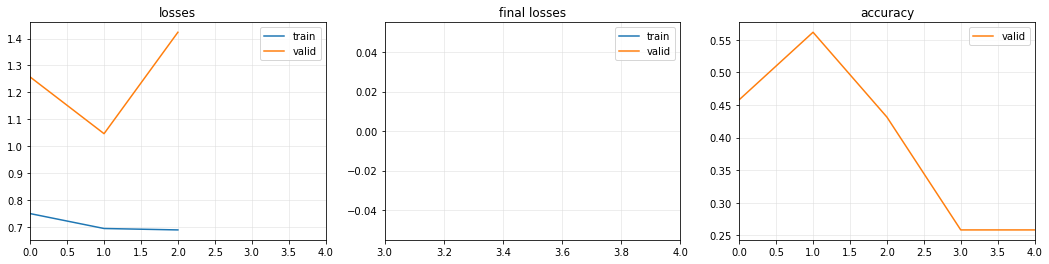

{'bias': False, 'bidirectional': True, 'fc_dropout': 0.8, 'hidden_size': 100, 'n_layers': 1, 'plus': True, 'rnn_dropout': 0.6}
 56%|█████████████████████████████████▌                          | 14/25 [40:52<36:00, 196.39s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



No improvement since epoch 0: early stopping                                                                            
 56%|█████████████████████████████████▌                          | 14/25 [41:19<36:00, 196.39s/trial, best loss: 0.4335]

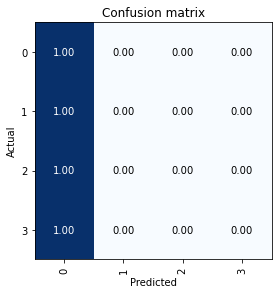

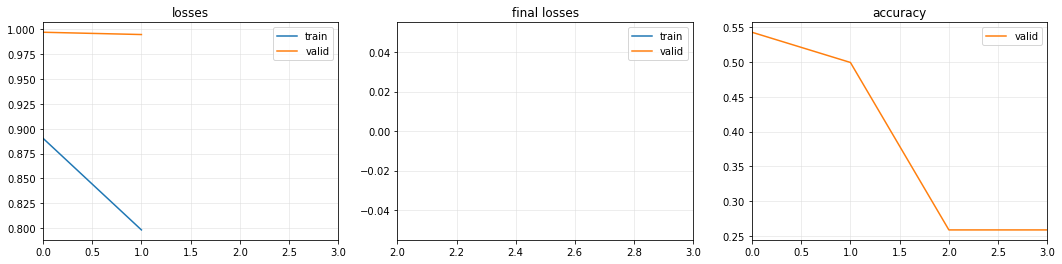

{'bias': False, 'bidirectional': False, 'fc_dropout': 0.6, 'hidden_size': 250, 'n_layers': 1, 'plus': False, 'rnn_dropout': 0.8}
 60%|████████████████████████████████████                        | 15/25 [41:20<24:17, 145.71s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



No improvement since epoch 0: early stopping                                                                            
 60%|████████████████████████████████████                        | 15/25 [41:48<24:17, 145.71s/trial, best loss: 0.4335]

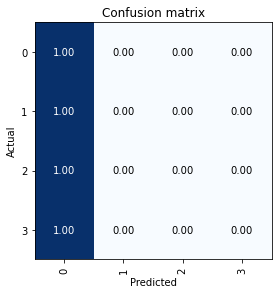

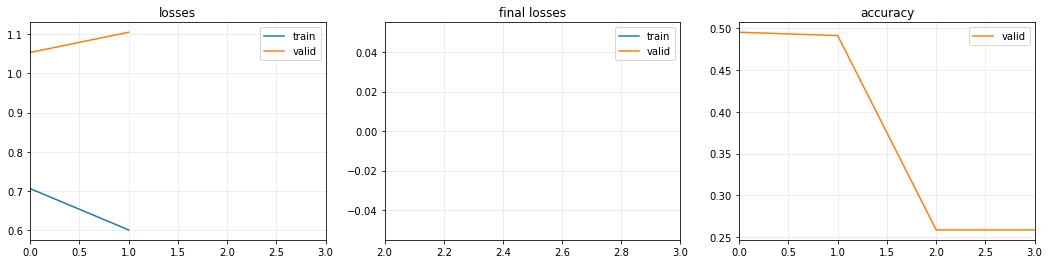

{'bias': False, 'bidirectional': False, 'fc_dropout': 0.8, 'hidden_size': 100, 'n_layers': 5, 'plus': False, 'rnn_dropout': 0.6}
 64%|██████████████████████████████████████▍                     | 16/25 [41:50<16:37, 110.79s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 64%|██████████████████████████████████████▍                     | 16/25 [42:53<16:37, 110.79s/trial, best loss: 0.4335]

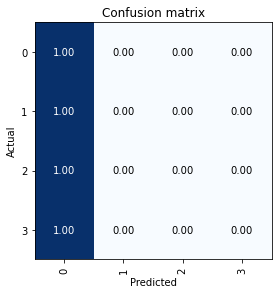

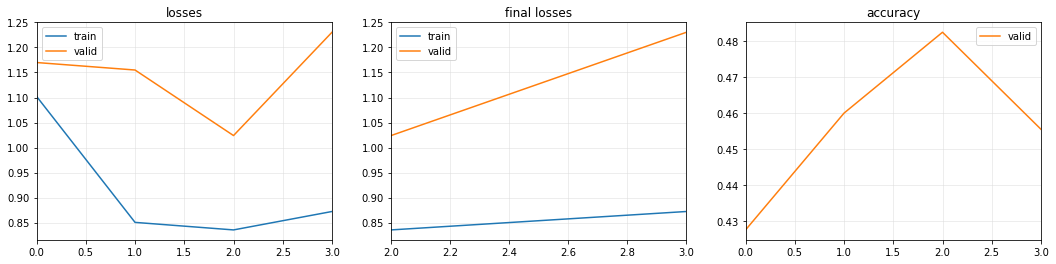

{'bias': False, 'bidirectional': True, 'fc_dropout': 0.8, 'hidden_size': 100, 'n_layers': 10, 'plus': True, 'rnn_dropout': 0.6}
 68%|█████████████████████████████████████████▍                   | 17/25 [42:55<12:56, 97.07s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 1: early stopping                                                                            
 68%|█████████████████████████████████████████▍                   | 17/25 [47:21<12:56, 97.07s/trial, best loss: 0.4335]

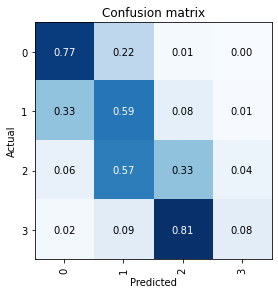

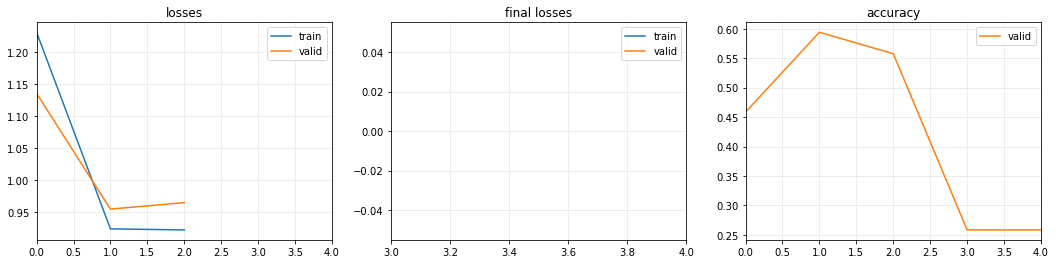

{'bias': False, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 250, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0.8}
 72%|███████████████████████████████████████████▏                | 18/25 [47:24<17:22, 148.87s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 72%|███████████████████████████████████████████▏                | 18/25 [52:14<17:22, 148.87s/trial, best loss: 0.4335]

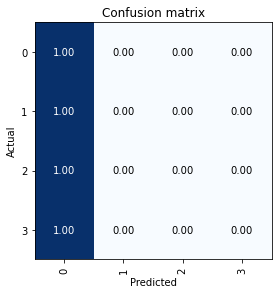

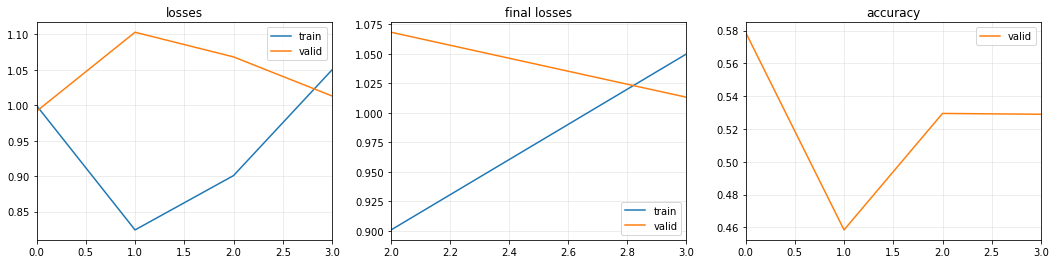

{'bias': False, 'bidirectional': False, 'fc_dropout': 0.4, 'hidden_size': 200, 'n_layers': 10, 'plus': True, 'rnn_dropout': 0.8}
 76%|█████████████████████████████████████████████▌              | 19/25 [52:19<19:16, 192.69s/trial, best loss: 0.4335]

No improvement since epoch 1: early stopping                                                                            
 76%|█████████████████████████████████████████████▌              | 19/25 [55:39<19:16, 192.69s/trial, best loss: 0.4335]

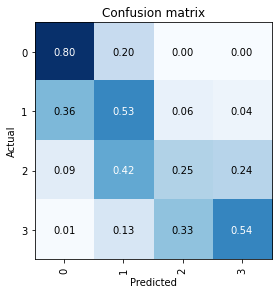

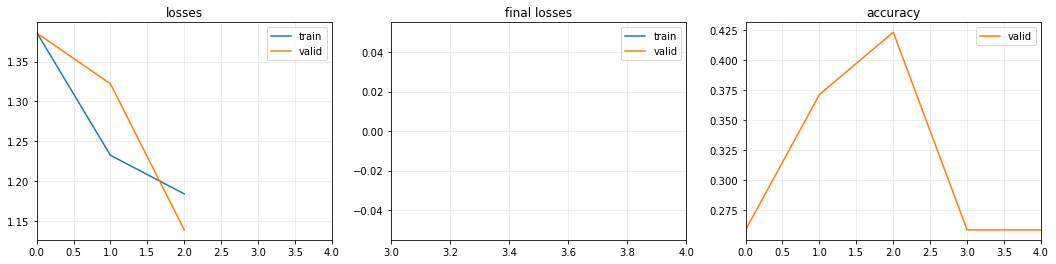

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 150, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0}
 80%|████████████████████████████████████████████████            | 20/25 [55:42<16:18, 195.70s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 80%|████████████████████████████████████████████████            | 20/25 [58:03<16:18, 195.70s/trial, best loss: 0.4335]

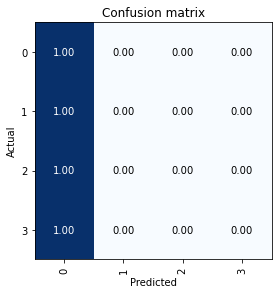

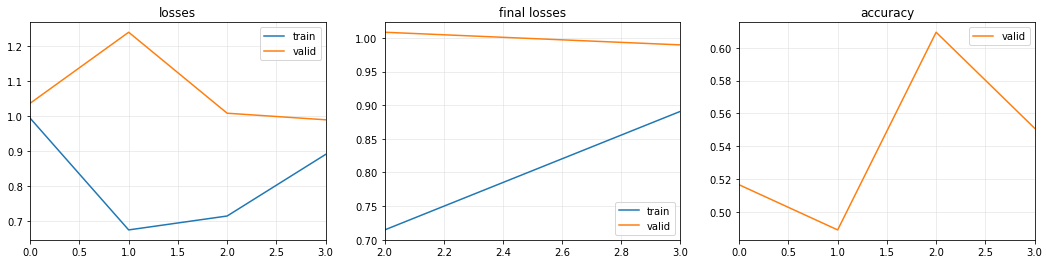

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 150, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0}
 84%|██████████████████████████████████████████████████▍         | 21/25 [58:07<12:02, 180.50s/trial, best loss: 0.4335]

No improvement since epoch 0: early stopping                                                                            
 84%|████████████████████████████████████████████████▋         | 21/25 [1:00:29<12:02, 180.50s/trial, best loss: 0.4335]

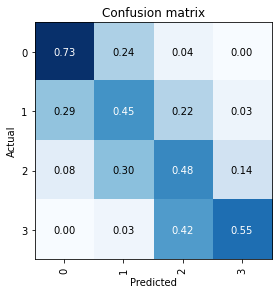

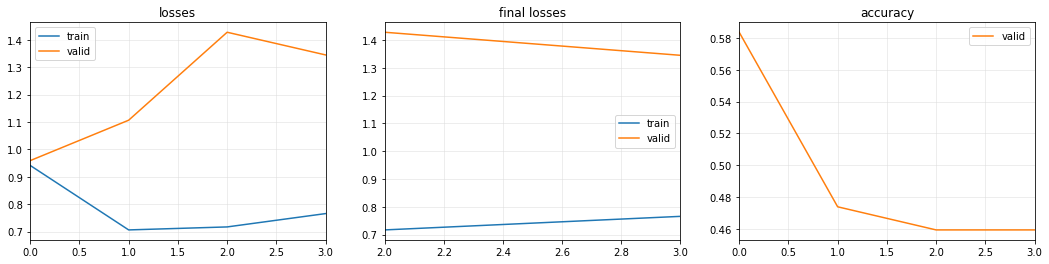

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 250, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0}
 88%|███████████████████████████████████████████████████       | 22/25 [1:00:32<08:29, 169.93s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 88%|███████████████████████████████████████████████████       | 22/25 [1:04:02<08:29, 169.93s/trial, best loss: 0.4335]

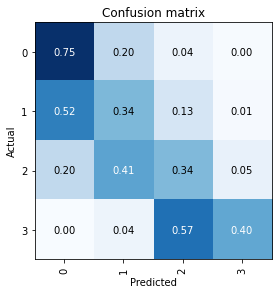

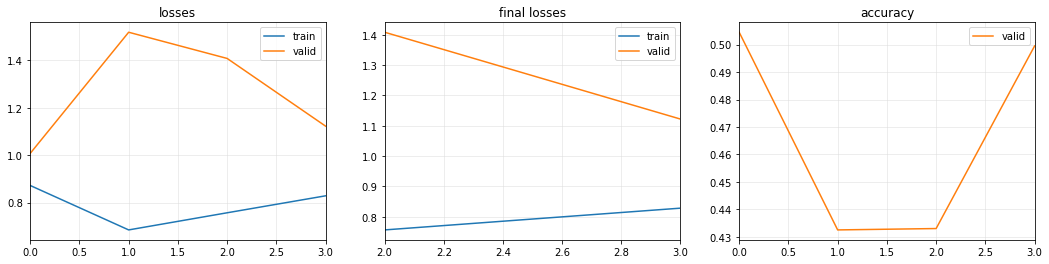

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 150, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0}
 92%|█████████████████████████████████████████████████████▎    | 23/25 [1:04:07<06:06, 183.38s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 0: early stopping                                                                            
 92%|█████████████████████████████████████████████████████▎    | 23/25 [1:06:29<06:06, 183.38s/trial, best loss: 0.4335]

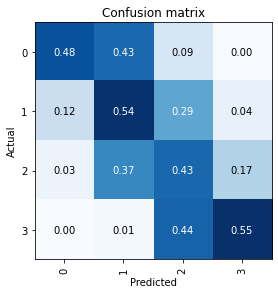

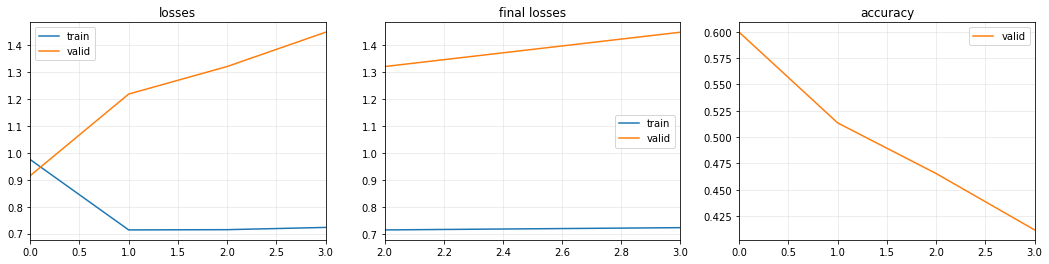

{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 250, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0}
 96%|███████████████████████████████████████████████████████▋  | 24/25 [1:06:33<02:52, 172.03s/trial, best loss: 0.4335]

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



No improvement since epoch 2: early stopping                                                                            
 96%|███████████████████████████████████████████████████████▋  | 24/25 [1:11:46<02:52, 172.03s/trial, best loss: 0.4335]

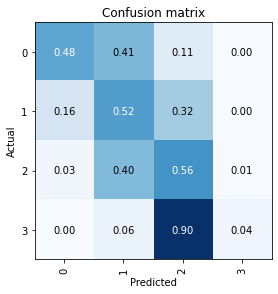

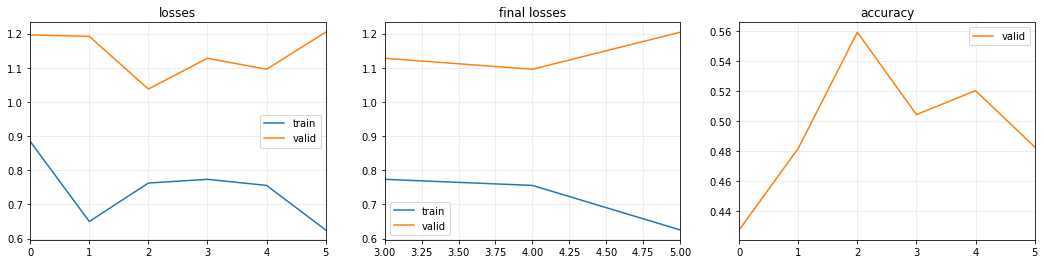

100%|██████████████████████████████████████████████████████████| 25/25 [1:11:51<00:00, 172.45s/trial, best loss: 0.4335]


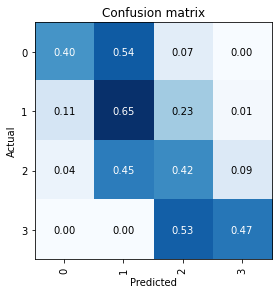

In [35]:
best = fmin(
        fn=objective_lstm,
        space=space_lstm,
        algo=tpe.suggest,
        max_evals=25
)

In [43]:
#{'arch': 'InceptionTimePlus', 'bottleneck': True, 'coord': True, 'dropout': 0.8, 'ks': 5}  
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardize(by_var=True), Nan2Value()], num_workers=0)
model = InceptionTimePlus(dls.vars, dls.c, bottleneck=True, coord=True, ks=5, conv_dropout=.8, stride=1)
learn = Learner(dls, model, metrics=accuracy)   

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)
/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [47]:
#{'bias': True, 'bidirectional': True, 'fc_dropout': 0.6, 'hidden_size': 250, 'n_layers': 8, 'plus': True, 'rnn_dropout': 0}
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardize(by_var=True), Nan2Value()], num_workers=0)
model = LSTMPlus(dls.vars, dls.c, hidden_size=250, n_layers=8, bias=True, rnn_dropout=0, bidirectional=False, fc_dropout=0.6)
learn = Learner(dls, model, metrics=accuracy)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)
/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.005248074419796467)

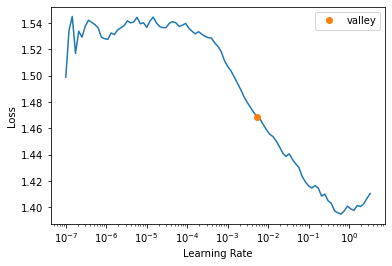

In [41]:
learn.lr_find()

In [1]:
learn.fit_one_cycle(10, lr_max=1e-2)#, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=5), SaveModelCallback(every_epoch=True)])
learn.recorder.plot_metrics()
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

print(accuracy_local(interp))

NameError: name 'learn' is not defined

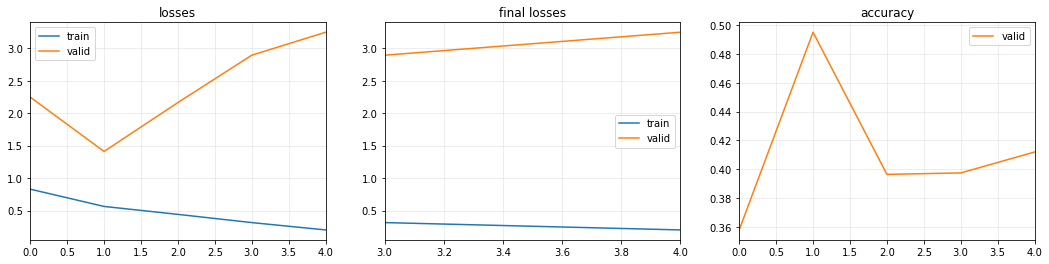

0.412


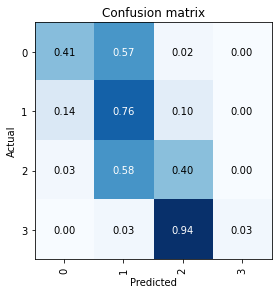

In [31]:
learn.fit_one_cycle(5, lr_max=1e-2)#, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=5))
learn.recorder.plot_metrics()
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

print(accuracy_local(interp))

In [132]:
ordered_label_errors.shape

(1175,)

In [125]:
[[x for x in splits_2[0] if x not in ordered_label_errors], splits_2[1]]

[[5286,
  8484,
  4451,
  1770,
  3640,
  7223,
  7255,
  7589,
  9521,
  3874,
  1636,
  6694,
  8886,
  1275,
  4007,
  382,
  5661,
  9455,
  1954,
  6102,
  1244,
  7115,
  1324,
  8444,
  6036,
  2074,
  9121,
  7373,
  2229,
  7925,
  7591,
  9313,
  5551,
  3262,
  1595,
  9104,
  613,
  9614,
  1974,
  7047,
  8621,
  3754,
  8878,
  1547,
  4317,
  1075,
  7937,
  1976,
  5820,
  3261,
  6798,
  6450,
  2637,
  4364,
  5364,
  9053,
  9182,
  1729,
  4907,
  5878,
  3245,
  3666,
  6914,
  831,
  3549,
  54,
  6604,
  2276,
  331,
  3100,
  73,
  629,
  75,
  4354,
  5669,
  4323,
  5448,
  1263,
  5229,
  6859,
  7073,
  9689,
  7252,
  7099,
  9262,
  5566,
  5155,
  48,
  2914,
  9753,
  588,
  7570,
  6908,
  9587,
  5058,
  7284,
  6123,
  6671,
  6875,
  1088,
  2343,
  1053,
  2335,
  3703,
  2179,
  1516,
  6049,
  5992,
  5249,
  5548,
  1799,
  8139,
  3926,
  1269,
  8734,
  2778,
  7692,
  799,
  8597,
  8341,
  9679,
  980,
  3578,
  3961,
  7792,
  3699,
  1164,


arch: InceptionTimePlus(c_in=771 c_out=4 seq_len=180 device=cuda:0, kwargs={})


/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/tsai/utils.py:634: RuntimeWarning: Mean of empty slice
  output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)
/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


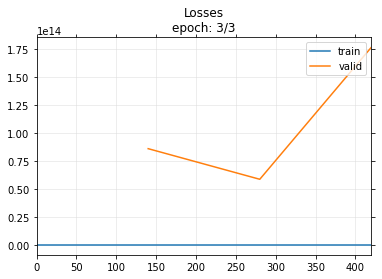

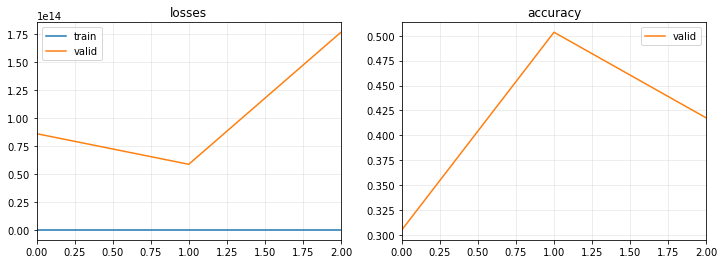

In [45]:
batch_tfms = [TSStandardize(by_var=True), Nan2Value()]
clf = TSClassifier(X, y, splits=[[x for x in splits_2[0] if x not in ordered_label_errors], splits_2[1]], arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph(), verbose=True)
clf.fit_one_cycle(3, 1e-2)

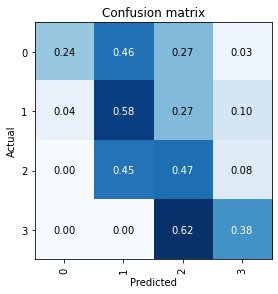

In [46]:
interp = ClassificationInterpretation.from_learner(clf)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

In [35]:
feature_names = pd.read_csv(ml_path + '/FeatureLabels_' + file_label + '.csv')
feature_names = feature_names['0'].sort_values().values

In [36]:
feature_names.shape

(774,)

In [37]:
X.shape

(12000, 774, 180)

In [38]:
import xarray as xr

In [39]:
da = xr.DataArray(X, dims=['sample','feature', 'timestep'], coords=[range(0,12000),feature_names,range(0,180)])

In [40]:
feature_names

array(['ABSV_1000mb_avg', 'ABSV_1000mb_max', 'ABSV_1000mb_min',
       'ABSV_100mb_avg', 'ABSV_100mb_max', 'ABSV_100mb_min',
       'ABSV_10mb_avg', 'ABSV_10mb_max', 'ABSV_10mb_min',
       'ABSV_150mb_avg', 'ABSV_150mb_max', 'ABSV_150mb_min',
       'ABSV_200mb_avg', 'ABSV_200mb_max', 'ABSV_200mb_min',
       'ABSV_20mb_avg', 'ABSV_20mb_max', 'ABSV_20mb_min',
       'ABSV_250mb_avg', 'ABSV_250mb_max', 'ABSV_250mb_min',
       'ABSV_300mb_avg', 'ABSV_300mb_max', 'ABSV_300mb_min',
       'ABSV_30mb_avg', 'ABSV_30mb_max', 'ABSV_30mb_min',
       'ABSV_350mb_avg', 'ABSV_350mb_max', 'ABSV_350mb_min',
       'ABSV_400mb_avg', 'ABSV_400mb_max', 'ABSV_400mb_min',
       'ABSV_450mb_avg', 'ABSV_450mb_max', 'ABSV_450mb_min',
       'ABSV_500mb_avg', 'ABSV_500mb_max', 'ABSV_500mb_min',
       'ABSV_50mb_avg', 'ABSV_50mb_max', 'ABSV_50mb_min',
       'ABSV_550mb_avg', 'ABSV_550mb_max', 'ABSV_550mb_min',
       'ABSV_600mb_avg', 'ABSV_600mb_max', 'ABSV_600mb_min',
       'ABSV_650mb_avg', 'ABSV_65

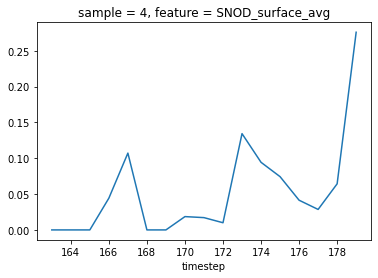

In [41]:
da.sel(feature='SNOD_surface_avg', sample=4).plot()

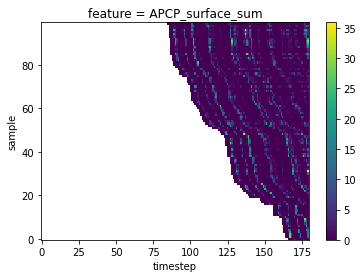

In [42]:
da.sel(feature='APCP_surface_sum', sample=range(0,100)).plot()

In [43]:
y.shape


(12000,)

In [44]:
#X, y, splits = get_classification_data('ECG200', split_data=False)

In [45]:
X.shape

(12000, 774, 180)

In [152]:
da.sel(feature=feature, timestep=timestep).values.reshape(6500,len(feature),len(timestep))[splits_2[0][8]][7]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  2.,
        1., 17.,  3., 16.,  0.,  0.,  0.,  0.,  0.,  3.,  5.,  0.,  0.,
        0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  6., 11.,  4.,  0.,  0.,
        0.,  5.,  2.,  6.,  1.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  5.,  1.,  0.,  0.,  0.,
        4.,  0.,  3.,  2.,  1.,  1.,  0.,  4.,  2.,  0.,  0.,  0.,  0.,
        2.,  6.,  0.,  0.,  0.,  7.,  5.,  0.,  0.,  0.,  4.,  1.,  9.,
        3.,  0.,  1.,  4.,  0.,  9.,  7.,  1.,  0.,  4.,  0.,  0.,  0.,
        0.,  0.,  2.,  3.,  3.,  9.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,
       10., 13.,  6.,  1.,  1.,  4.,  1.,  1.,  6.,  5.,  1.,  0.,  0.,
        0.,  1.,  8.,  7., 24.,  4.,  0.,  6., 18.,  2., 11.,  0.,  4.,
        2., 26.,  5.,  0.,  0.,  0.,  0.,  1.,  0.,  1., 10.,  2.,  2.,
        0.,  0.,  0.,  0.,  2.,  3.,  2.,  1.,  1.,  5.,  0.,  0.,  1.,
        2.,  0.,  0., 11.,  7.,  4.,  2.,  0.,  0.,  0.,  1.],
 

In [60]:
timestep=range(0,180)
feature = ['WEASD_surface_max', 'SNOD_surface_max', 'UGRD_30M0mbaboveground_max', 'VGRD_30M0mbaboveground_max', 'TMP_surface_min', 'HGT_surface_min', 'VVEL_150mb_avg', 'APCP_surface_sum', 'ACPCP_surface_sum', 'WATR_surface_sum']
bad_features = ['PRES_surface_max', 'TSOIL_1M2mbelowground_max', 'TMP_surface_min', 'RH_2maboveground_max']
tfms = [None, [Categorize()]]
X = da.sel(feature=feature, timestep=timestep).values.reshape(12000,len(feature),len(timestep))
dsets2 = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)
#create the dataloader
dls2 = TSDataLoaders.from_dsets(dsets2.train, dsets2.valid, bs=[64], batch_tfms=[TSStandardize(by_var=True), Nan2Value()], num_workers=0)

In [62]:
ts_features = get_ts_features(np.nan_to_num(X), y, n_jobs=20)

Feature Extraction: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.02it/s]


In [64]:
ts_features.shape

(12000, 81)

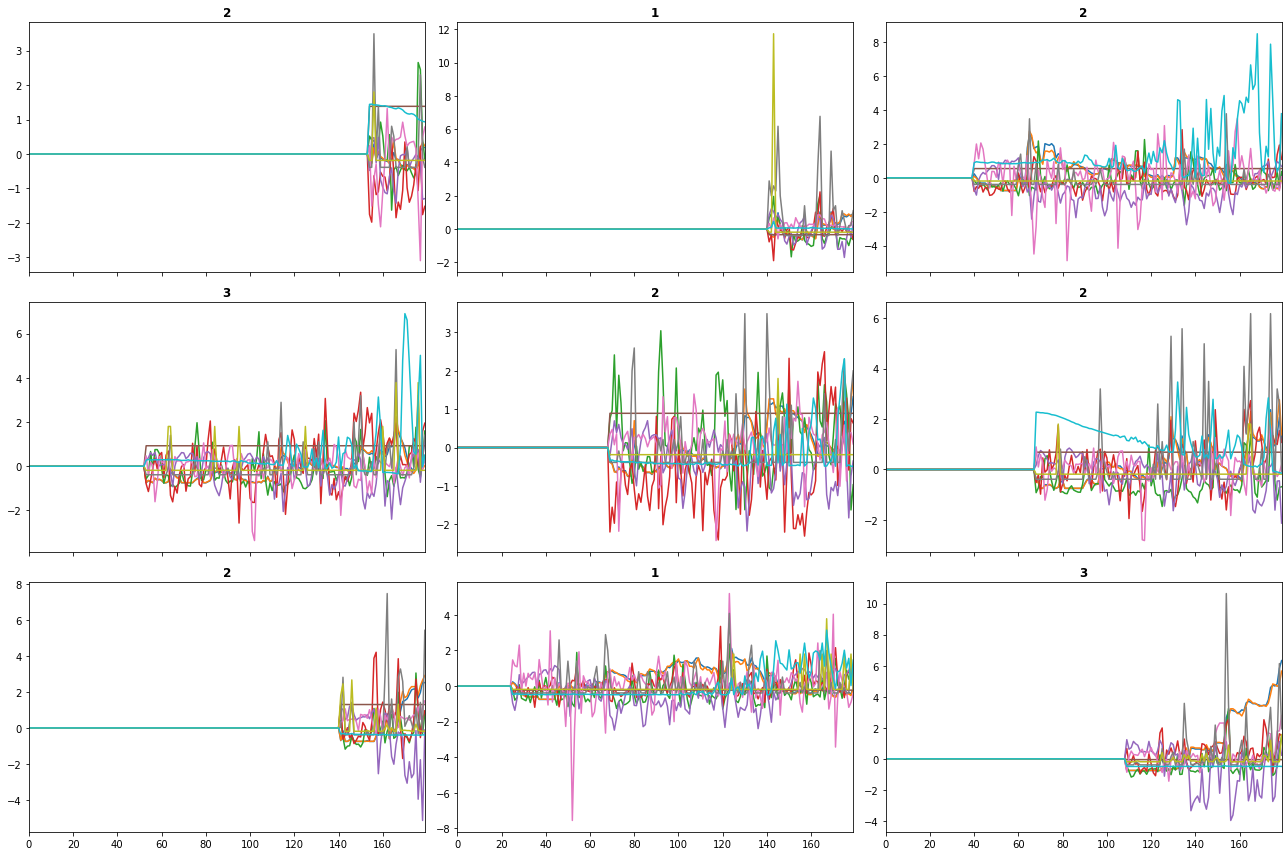

In [47]:
dls2.train.show_batch()

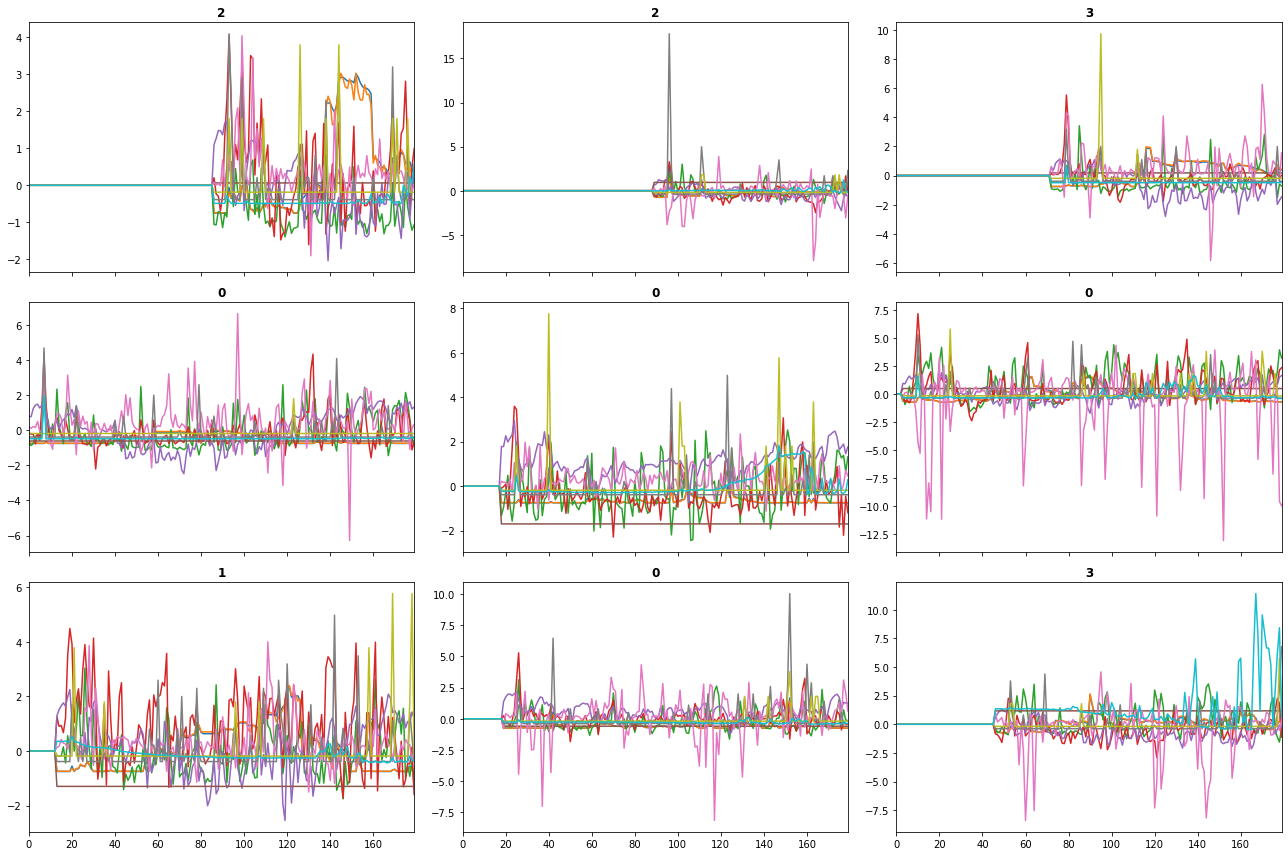

In [48]:
dls2.valid.show_batch()

In [58]:
??get_ts_features

In [53]:
#TST: 30: .29
#TST: 80: .2
#TST: 180: .4

#Try TST
model = InceptionTimePlus(dls2.vars, dls2.c, dls2.len)#, res_dropout=.3, fc_dropout=.8)
#config = {'res_dropout':.3, 'fc_dropout':.8}
learn = Learner(dls2, model, loss_func=LabelSmoothingCrossEntropy(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
#learn = TSClassifier( y, splits=splits_3, arch=TST, arch_config=config, batch_tfms=[TSStandardize(), Nan2Value()], metrics=accuracy, cbs=ShowGraph(), verbose=True)
#learn.fit_one_cycle(10, 1e-4)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0014454397605732083)

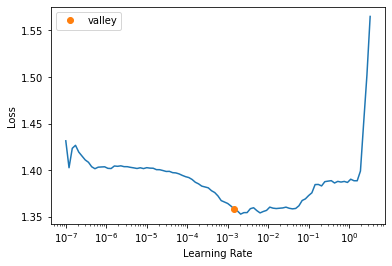

In [54]:
learn.lr_find()

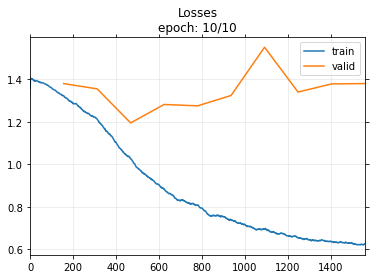

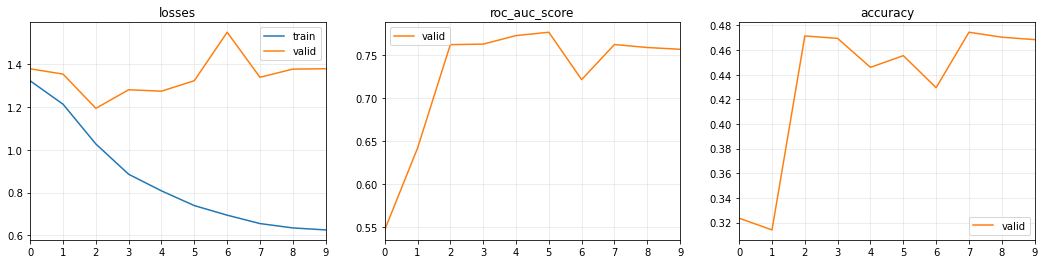

In [55]:
learn.fit_one_cycle(10, 1e-4)

NameError: name 'accuracy_local' is not defined

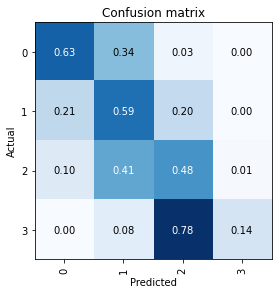

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

print(accuracy_local(interp))


In [246]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

/home/scottcha/miniconda3/envs/tsai2.22/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/__init__.py:2: MatplotlibDeprecationWarning: 
The deprecated function was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  from .axes_divider import Divider, SubplotDivider, LocatableAxes, \


In [331]:
net = learn.model.cpu()

In [332]:
b = dls.one_batch()

In [333]:
test_input_tensor = b[0].type(torch.FloatTensor)

In [334]:
test_labels = b[1].cpu().data.numpy()

In [335]:
out_probs = net(test_input_tensor).detach().cpu().numpy()
out_classes = np.argmax(out_probs, axis=1)
train_accuracy = sum(out_classes == test_labels) / len(test_labels)
print("Accuracy:", train_accuracy )

Accuracy: 0.734375


In [43]:
mlflow.log_metric('Train Accuracy', train_accuracy)

NameError: name 'mlflow' is not defined

In [336]:
ig = IntegratedGradients(net)

In [337]:
#test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

In [288]:
feature_names = feature_names[feature_filter]

NameError: name 'feature_filter' is not defined

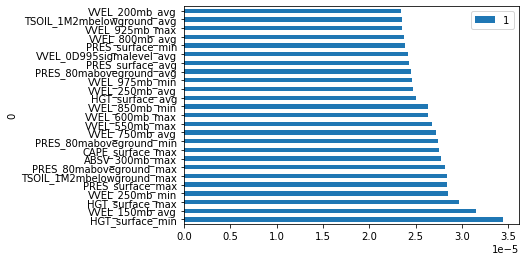

In [339]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    pd.DataFrame(zip(feature_names, np.mean(importances, axis=(0,2)))).sort_values(1, ascending=False)[:25].plot.barh(x=0, y=1)

visualize_importances(feature_names, attr)

In [50]:
top_features =  pd.DataFrame(zip(feature_names, np.mean(attr, axis=(0,2))), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

In [51]:
top_features.to_csv('../Scratch/Notebooks/' + '/FeatureImportances.csv')

In [29]:
top_features = pd.read_csv('../Scratch/Notebooks/' + '/FeatureImportances.csv')

In [85]:
orig_X = X

In [86]:
orig_feature_means = feature_means

In [87]:
orig_feature_std = feature_std

In [134]:
mlflow.end_run()

In [88]:
feature_filter = top_features[:100].index

In [89]:
X = orig_X[:, feature_filter, :]
feature_means = orig_feature_means[feature_filter]
feature_std = orig_feature_std[feature_filter]

In [35]:
fill_values = torch.zeros_like(TSTensor(X))
for i in range(0,X.shape[1]):
    fill_values[:,i,:] = torch.full_like(TSTensor(X[:,i,:]), feature_means[i])
        
X_noNan = torch.where(torch.isnan(TSTensor(X)), fill_values, TSTensor(X))

In [40]:
X_noNan[:,:,-30:].shape

torch.Size([6000, 100, 30])